In [6]:
import os
import threading

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam

from kfp import construct_A, construct_B, diffusion_coeff, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, logsumexp
from network import ScoreNet

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
    os.system("make -C ../sparse_gaussian_elimination a.so")


cifar = CIFAR10('.', download=True)


# download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

Files already downloaded and verified


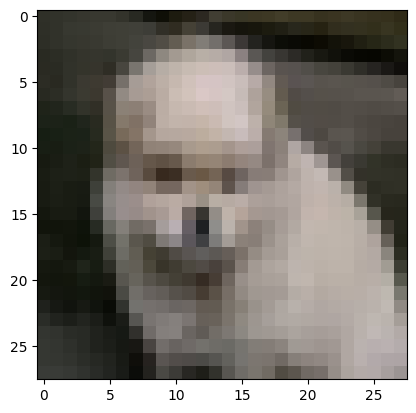

In [7]:

cifar_data_grey = [torch.Tensor(np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 28, 28))))]
cifar_data = [np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("RGB").crop((0, 0, 28, 28)))]
plt.imshow(cifar_data[0])
cifar_data = [torch.Tensor(np.moveaxis(cifar_data[0], 2, 0))]

In [8]:
## construct the grid and Initial values
batch_size = 32
N = 20
H = 28
W = 28
epoch = 60
eps = 1e-6

channels = 3

t = np.linspace(eps, 1, N)
dt = 1/N

sigma = 25

# create model
model_score = ScoreNet(H=H, W=W, in_channels=channels)
loss_fn = torch.nn.MSELoss()
optimizer = Adam(model_score.parameters(), lr=1e-3)
mm_scaler = MinMaxScaler()
model_score.train();

scores = np.zeros((N,channels, H, W), dtype=np.float32)

In [9]:
def diffuse(data, x, m , del_m, m_c, channel, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_):
    data = data[channel]
    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32)).reshape((1, 1, H, W))
    params = {"bandwidth": np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params)
    kde = grid.fit(data.ravel()[:, None])
    m[channel][0] = kde.score_samples(data.ravel()[:, None])
    del_m[channel][0] = np.diff(m[channel][0].ravel(), axis=0, prepend=m[channel][0,0])

    # we normalize for sigma to ensure the dynamics doesn't blow up
    A_block = []
    for i, t_ in enumerate(random_t, 1):
      A = construct_A(dx, dy, t_ - time_[i-1], np.zeros((H, W)), sigma_[i], scores[i][channel], H, W)
      if i == 1:
        A_block = sp.linalg.block_diag(A)
      else:
        A_block = sp.linalg.block_diag(A_block, A)
        A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])

    B = construct_B(dx, dy, time_[1] - time_[0], m[channel][0], np.zeros((H, W)), sigma_[1], scores[i][channel])
    B_block = np.zeros(A_block.shape[0])
    B_block[:H*W] = B

    # update m (pre-smoothing)
    m[channel][1:] = gauss_seidel(A_block, B_block, scores[1:, channel].flatten()).reshape(((N-1), H*W))
    R = construct_R(int(H/2), int(H))
    P = construct_P(R)
    R_block = []
    P_block = []
    for i, t_ in enumerate(random_t, 1):
      ####### kernal preserving restriction ####
      R_block = construct_R_block(R, R_block, i)
      ####### bilinear interpolation ###########
      P_block = construct_P_block(P, P_block, i)

    # we want to perform the coarse grid
    # compute residual r = b - Am[1:]
    r = B_block - A_block@(m[channel][1:]).flatten()
    # coursening step 1: r_c = R_c@r
    r_c = R_block@r
    # coursening A_c = R_c@A@P_c (Petrov-Galerkin Coursening)
    A_c = (sparse.csr_matrix(R_block)@sparse.csr_matrix(A_block)@sparse.csr_matrix(P_block)).toarray()
    # compute course err: err_c = solve_pde(A_c,r_c)
    err_c = solve_pde(A_c, r_c, mode='sparse')
    # interpolate to fine grid: err = P_c@err_c
    err = P_block@err_c
    # we apply fine grid-correction
    m[channel][1:] = (m[channel][1:].flatten() + err).reshape((N-1, H*W))
    # post smoothing
    m[channel][1:] = gauss_seidel(A_block, B_block, m[channel][1:].flatten()).reshape(((N-1), H*W))
    # we want to coarsen the score function to train on coarse data
    m_c[channel][1:] = (R_block@m[channel][1:].flatten()).reshape((-1, int(H*W/4)))

    # constructing the training data and labels
    for i, t_ in enumerate(random_t, 1):
      del_m[channel][i] = np.diff(m[channel][i].ravel(), axis=0, prepend=m[channel][i, 0])

    x = torch.tensor(mm_scaler.fit_transform(np.exp((-m[channel].ravel() - logsumexp(-m[channel].ravel())))[:, None])).reshape((N, 1, H, W))
    perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    train_x_data[:, channel] = perturbed_x[:, 0]
    train_y_data[:, channel] = torch.tensor(del_m[channel].astype(np.float32)).reshape((N, H, W))

    # generate coarse dataset
    x_c = torch.tensor(mm_scaler.fit_transform(np.exp((-m_c[channel].ravel() - logsumexp(-m_c[channel].ravel())))[:, None])).reshape((N, int(H/2), int(W/2)))
    perturbed_xc = x_c + torch.randn_like(x_c) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None]
    train_xc_data[:, channel] = perturbed_xc

  0%|          | 0/60 [00:00<?, ?it/s]

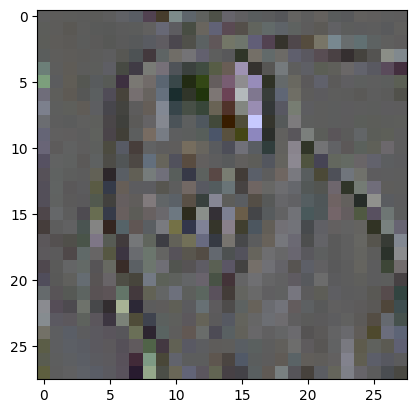

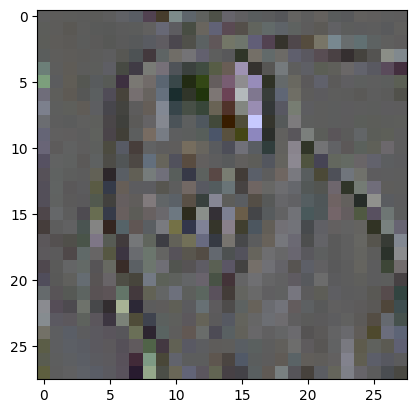

0.13329602777957916
0.11551355570554733


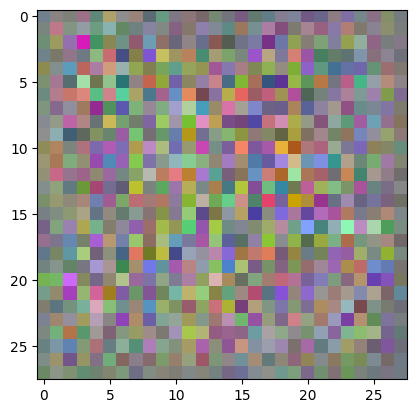

  2%|▏         | 1/60 [00:34<34:10, 34.75s/it]

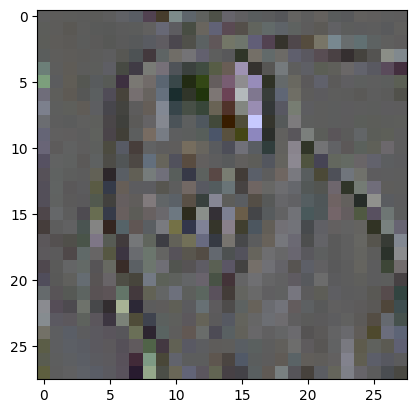

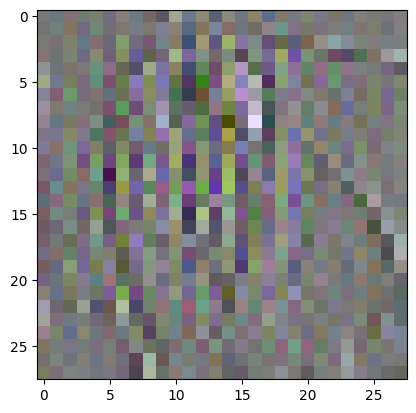

0.11706579476594925
0.1132717952132225


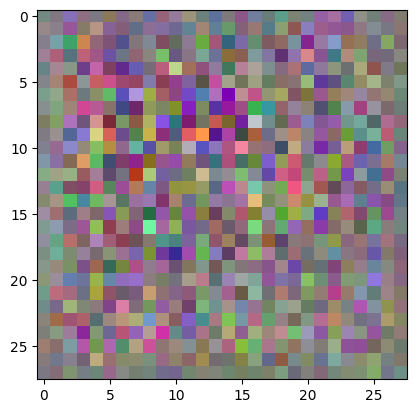

  3%|▎         | 2/60 [00:58<27:12, 28.15s/it]

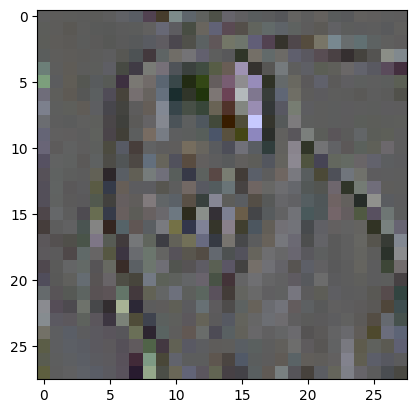

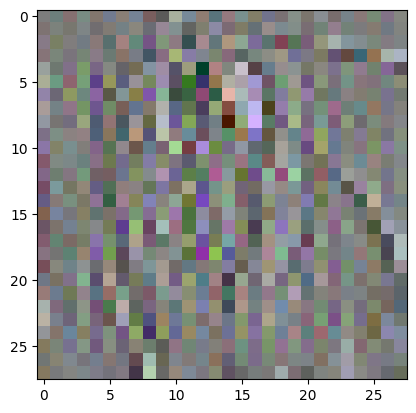

0.09397309273481369
0.0944238156080246


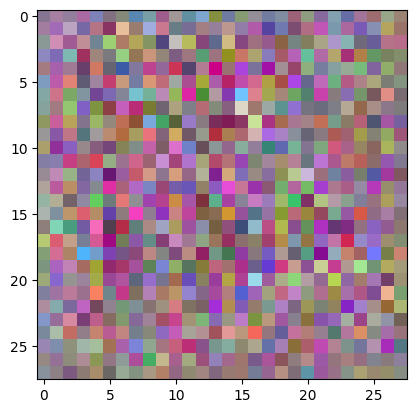

  5%|▌         | 3/60 [01:24<25:43, 27.07s/it]

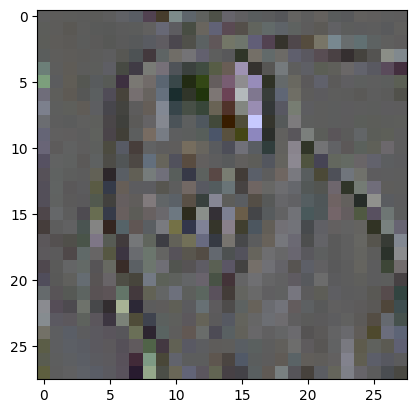

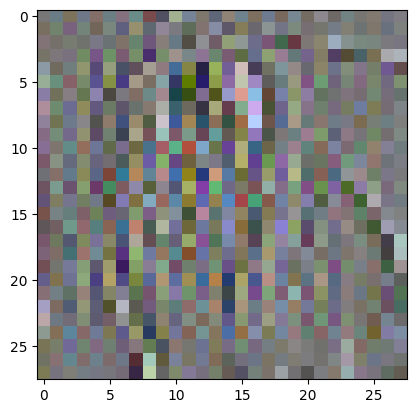

0.08608604222536087
0.09053806960582733


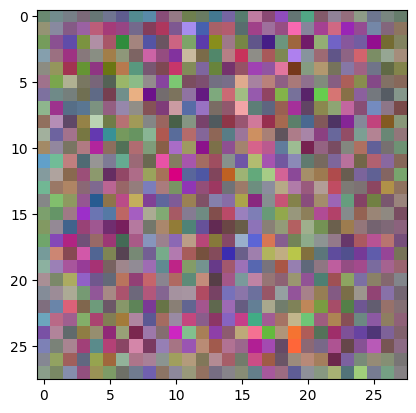

  7%|▋         | 4/60 [01:49<24:28, 26.23s/it]

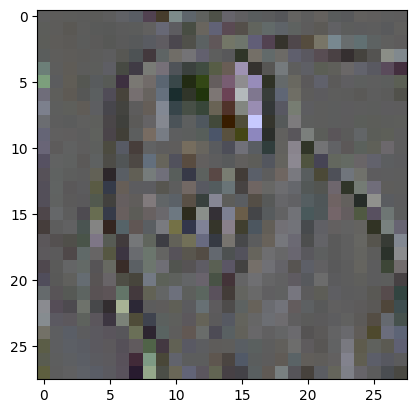

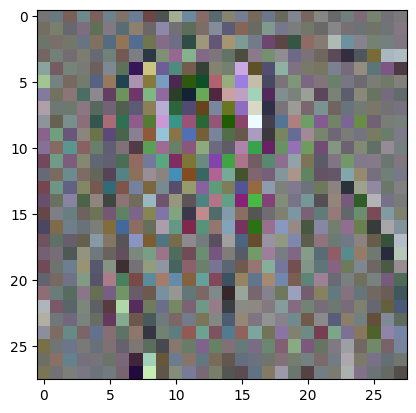

0.07354354113340378
0.08039660006761551


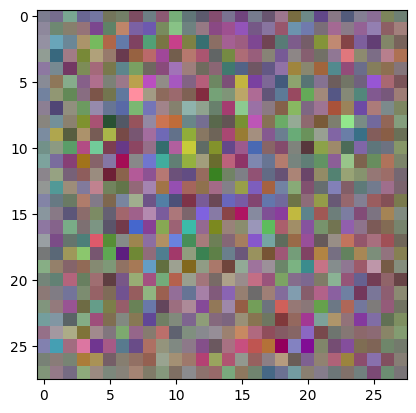

  8%|▊         | 5/60 [02:13<23:30, 25.65s/it]

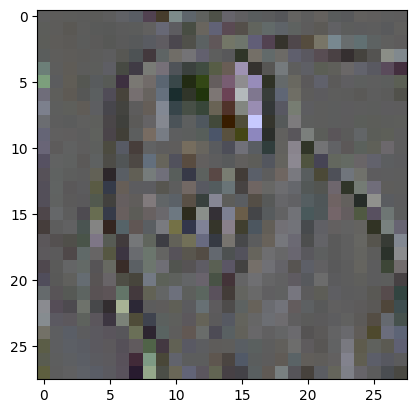

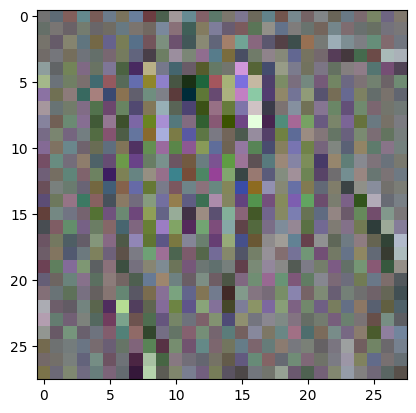

0.06958845257759094
0.07480494678020477


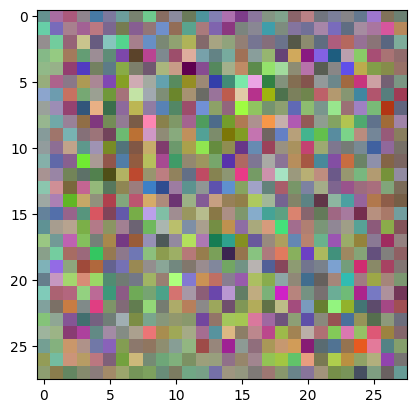

 10%|█         | 6/60 [02:39<23:10, 25.76s/it]

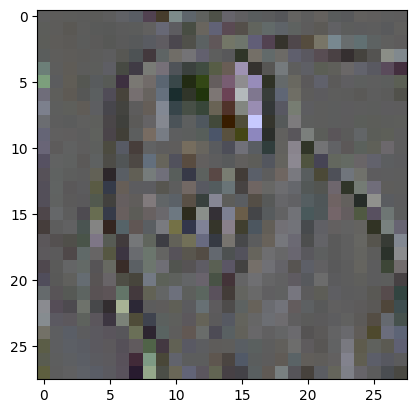

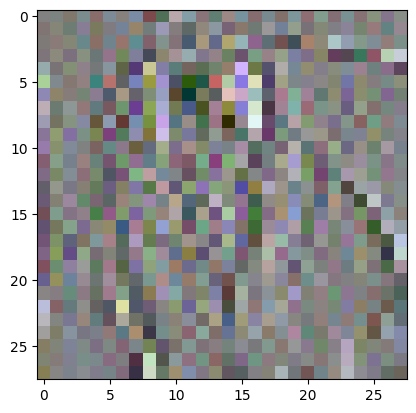

0.06455795466899872
0.06903097033500671


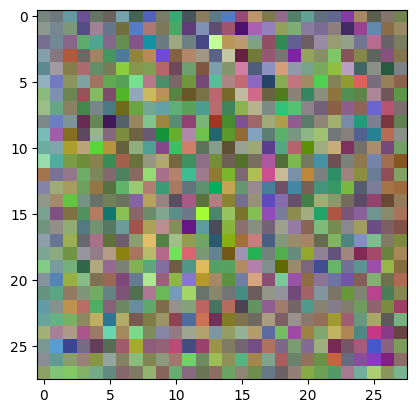

 12%|█▏        | 7/60 [03:06<23:00, 26.05s/it]

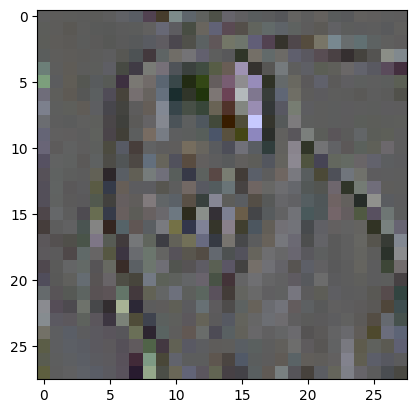

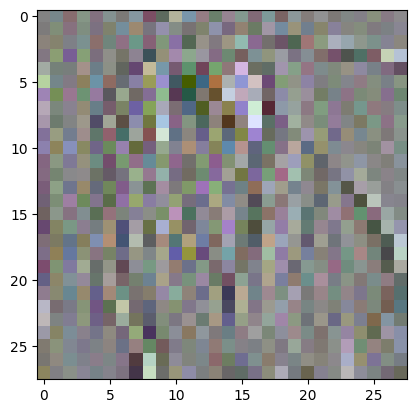

0.06121232360601425
0.06579793989658356


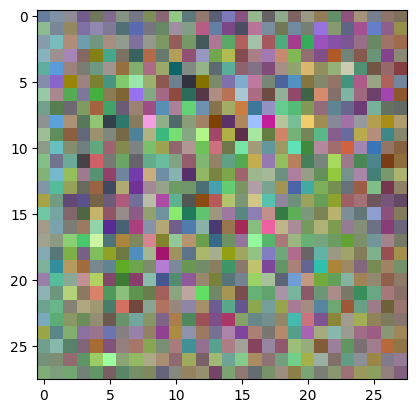

 13%|█▎        | 8/60 [03:31<22:22, 25.82s/it]

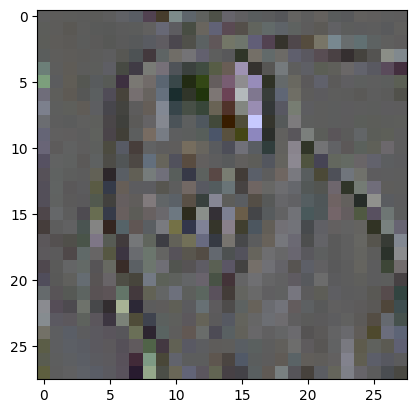

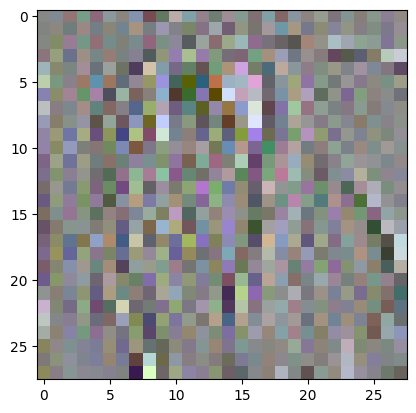

0.059379711747169495
0.06366364657878876


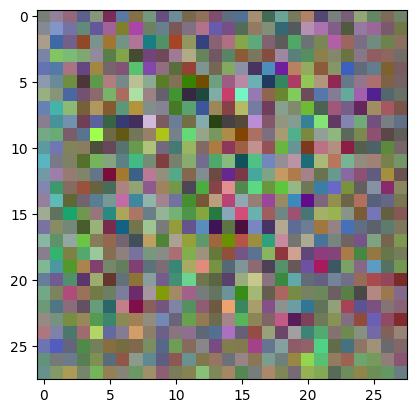

 15%|█▌        | 9/60 [03:55<21:20, 25.11s/it]

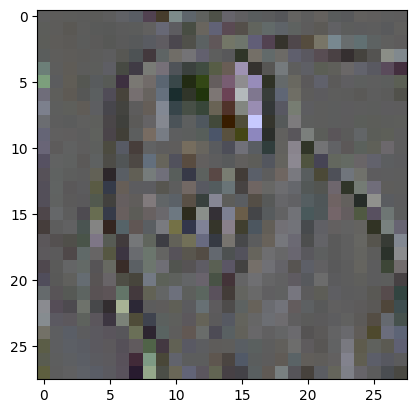

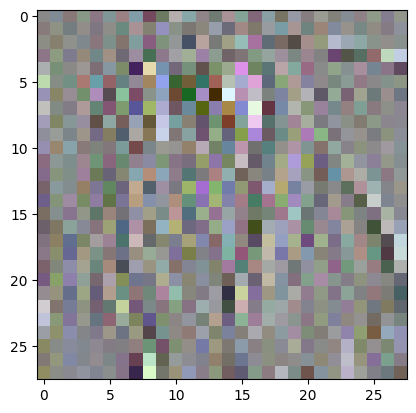

0.05651140213012695
0.061159439384937286


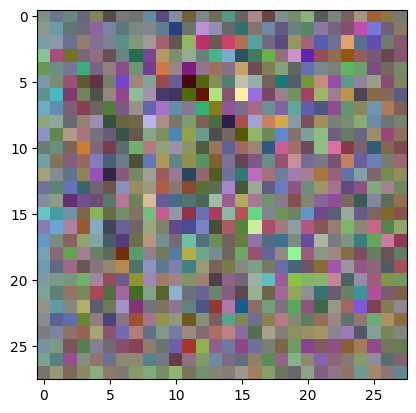

 17%|█▋        | 10/60 [04:25<22:20, 26.81s/it]

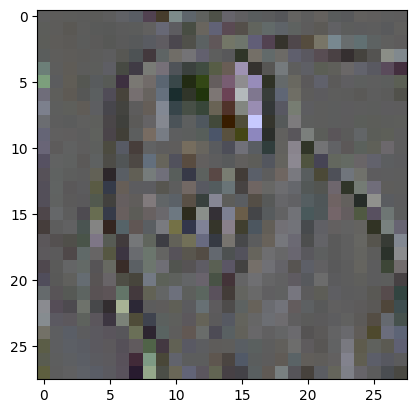

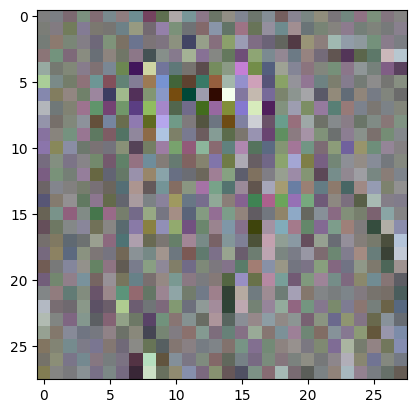

0.05482726916670799
0.05857653543353081


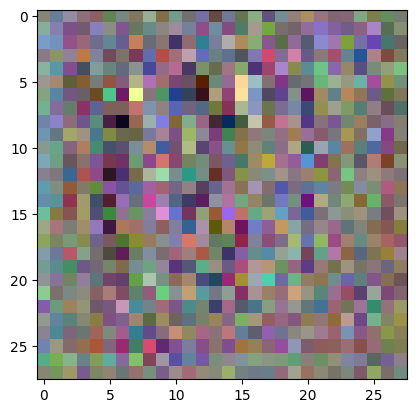

 18%|█▊        | 11/60 [04:53<22:13, 27.21s/it]

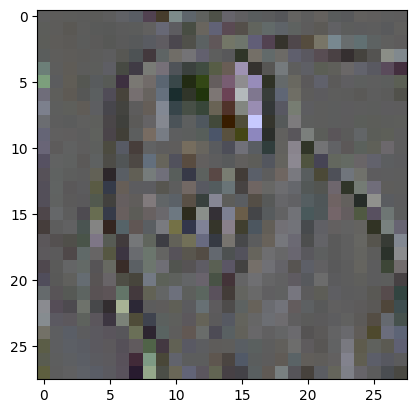

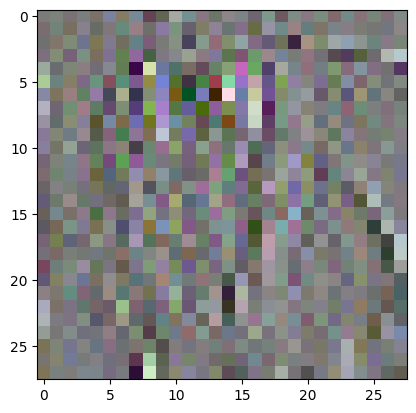

0.05313751846551895
0.05667180195450783


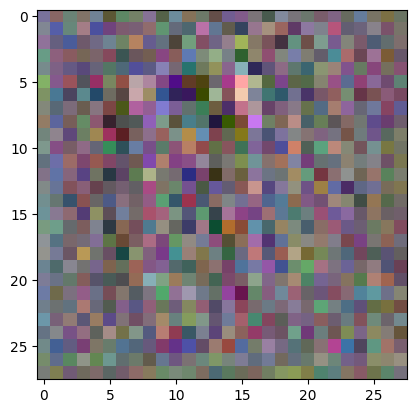

 20%|██        | 12/60 [05:21<21:50, 27.31s/it]

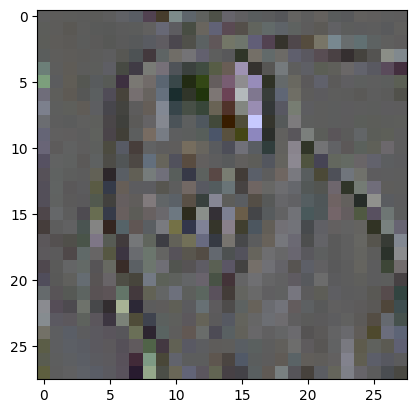

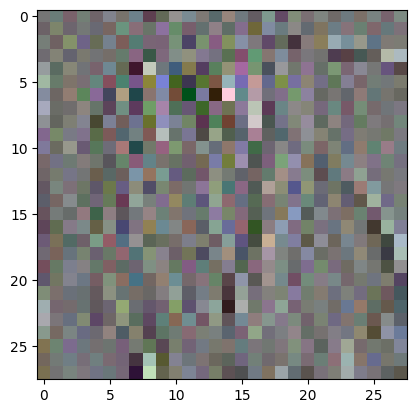

0.050342708826065063
0.053213346749544144


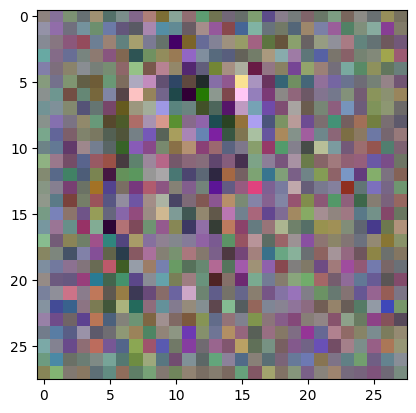

 22%|██▏       | 13/60 [05:50<21:55, 28.00s/it]

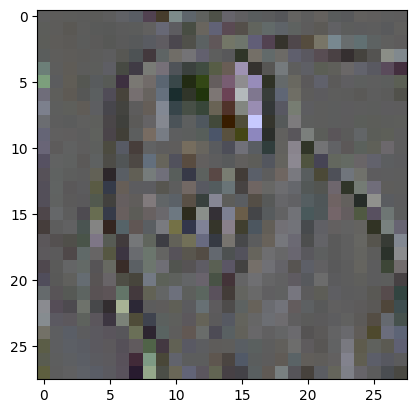

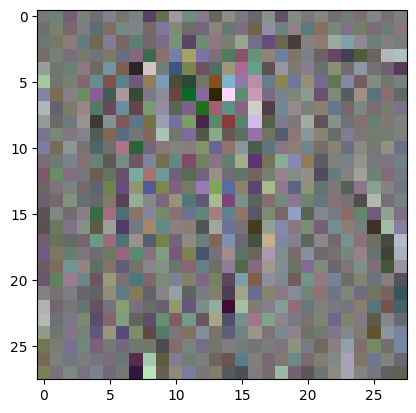

0.049077942967414856
0.05227399989962578


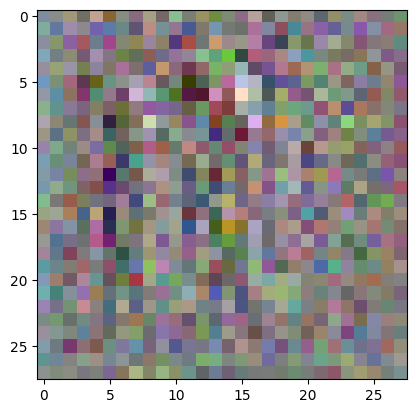

 23%|██▎       | 14/60 [06:12<19:58, 26.06s/it]

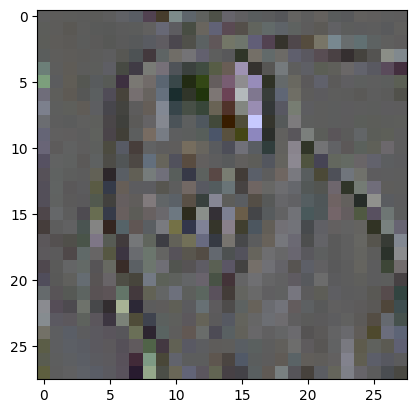

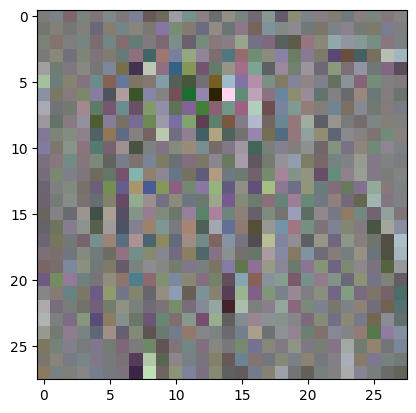

0.04796084016561508
0.05046040937304497


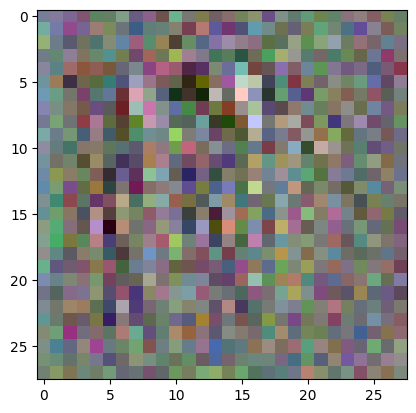

 25%|██▌       | 15/60 [06:44<20:48, 27.75s/it]

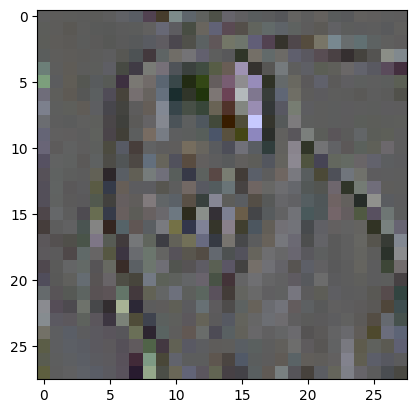

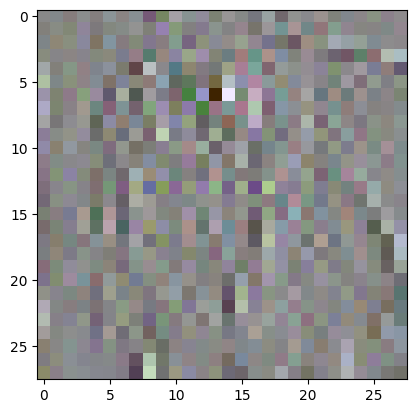

0.04659877344965935
0.0491880439221859


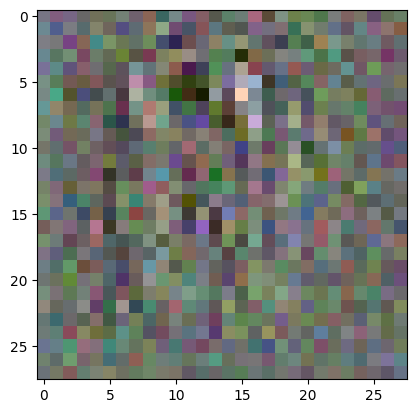

 27%|██▋       | 16/60 [07:08<19:36, 26.74s/it]

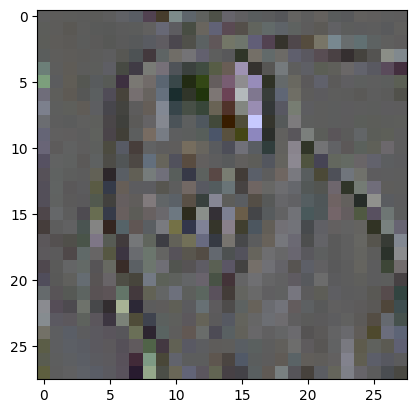

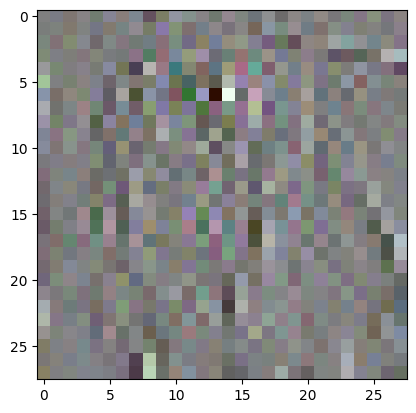

0.04427606984972954
0.04680710285902023


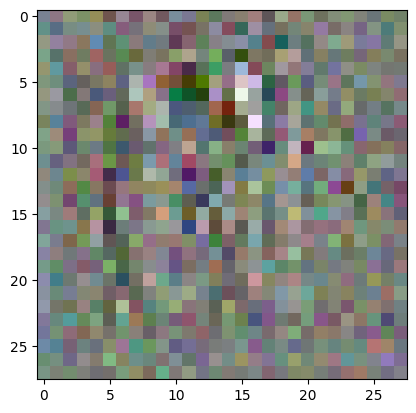

 28%|██▊       | 17/60 [07:34<18:59, 26.51s/it]

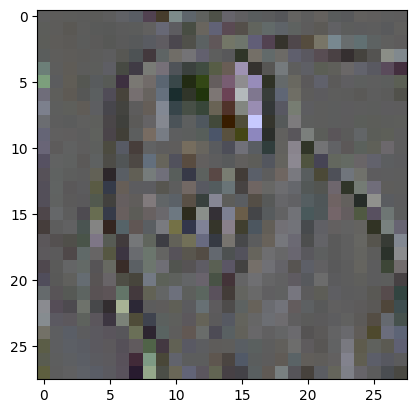

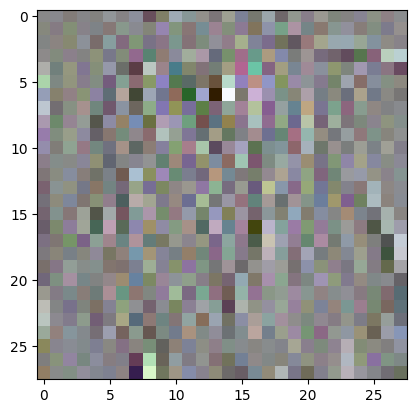

0.042132649570703506
0.0443418025970459


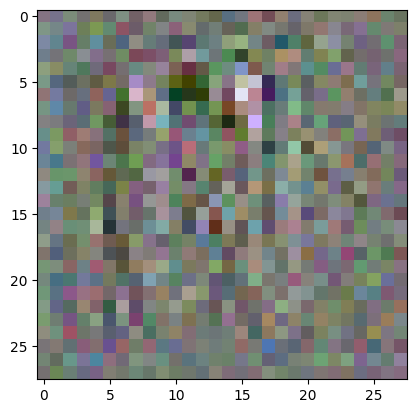

 30%|███       | 18/60 [07:59<18:07, 25.89s/it]

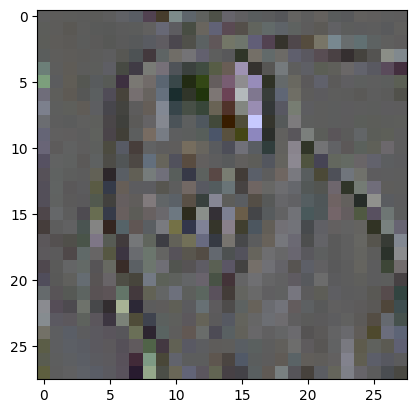

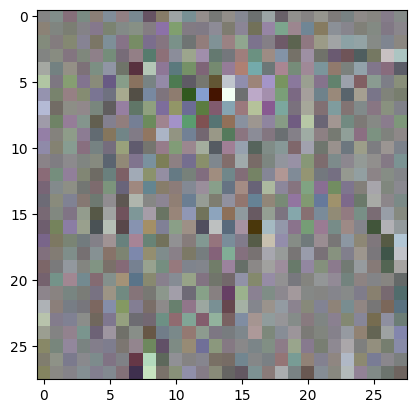

0.04047058895230293
0.04268309101462364


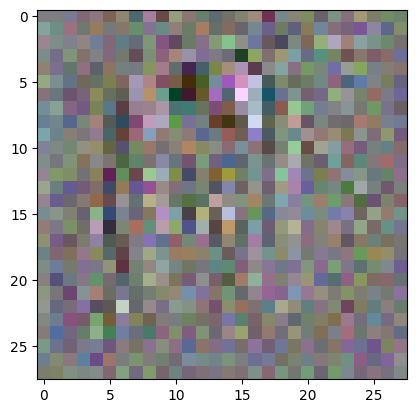

 32%|███▏      | 19/60 [08:21<16:56, 24.80s/it]

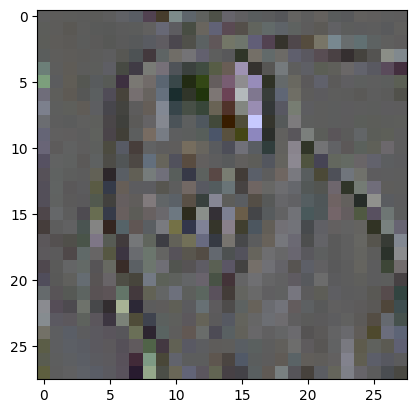

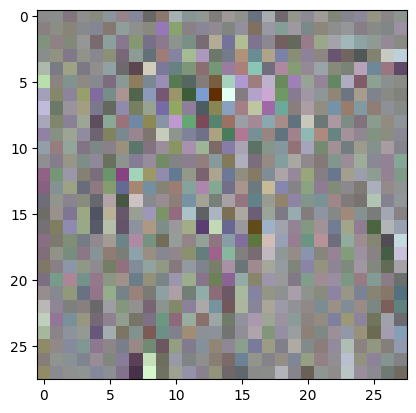

0.03857387974858284
0.040984444320201874


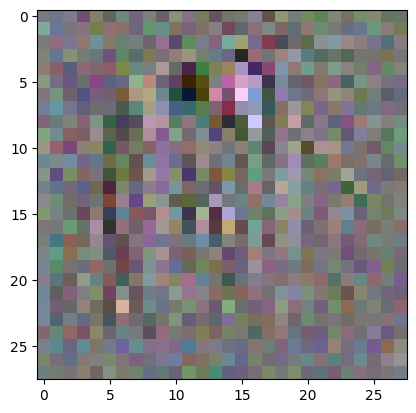

 33%|███▎      | 20/60 [08:44<16:11, 24.28s/it]

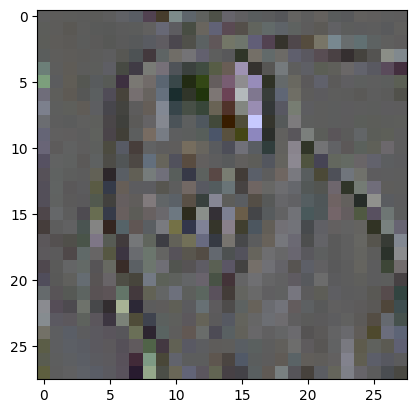

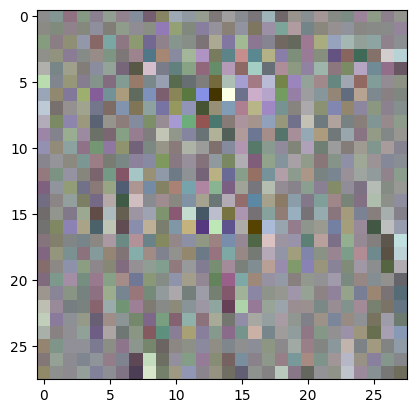

0.03820551186800003
0.040180351585149765


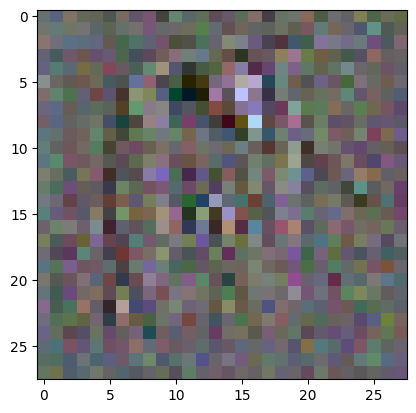

 35%|███▌      | 21/60 [09:08<15:50, 24.38s/it]

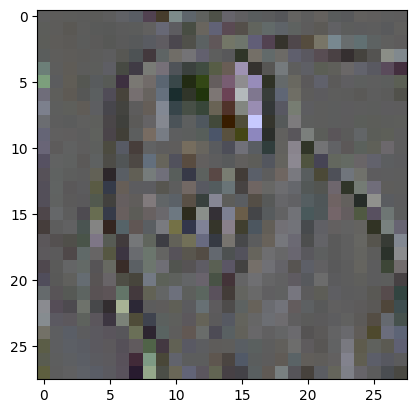

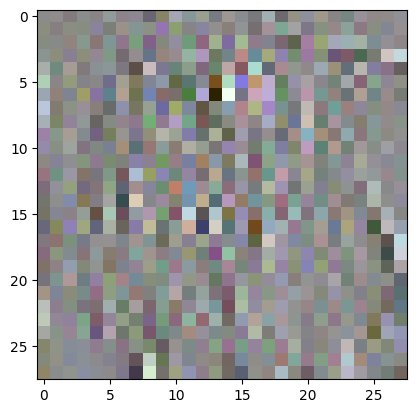

0.0363236665725708
0.038428597152233124


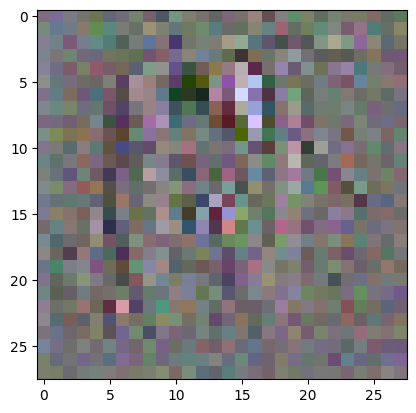

 37%|███▋      | 22/60 [09:33<15:32, 24.54s/it]

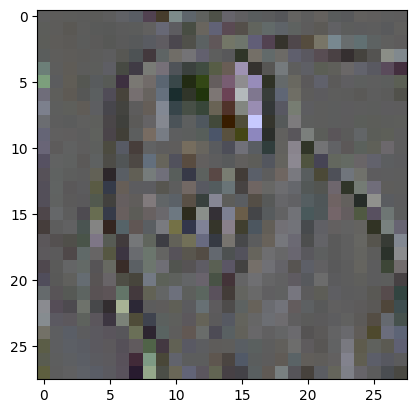

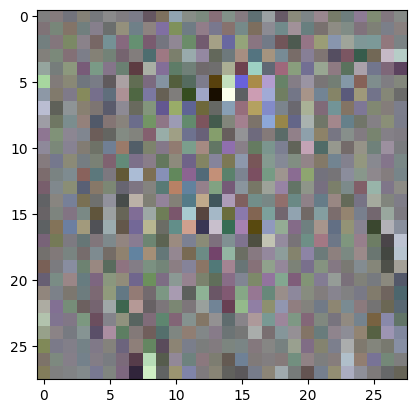

0.03557691350579262
0.03763171285390854


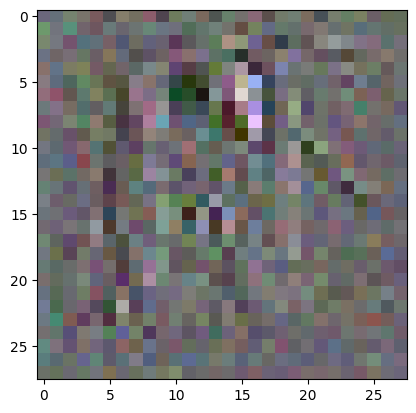

 38%|███▊      | 23/60 [09:57<14:56, 24.22s/it]

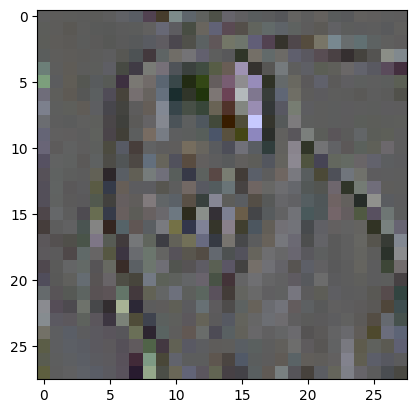

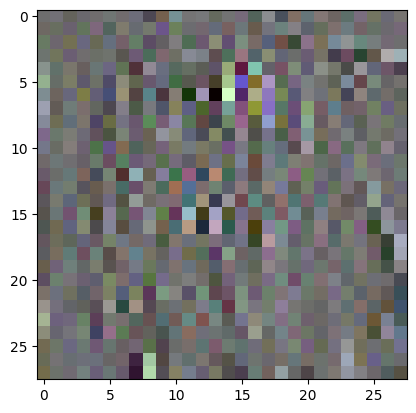

0.03509971871972084
0.03692866861820221


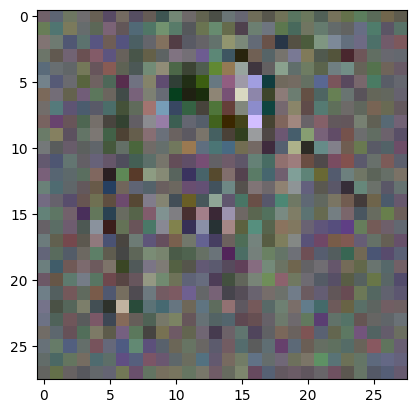

 40%|████      | 24/60 [10:21<14:31, 24.22s/it]

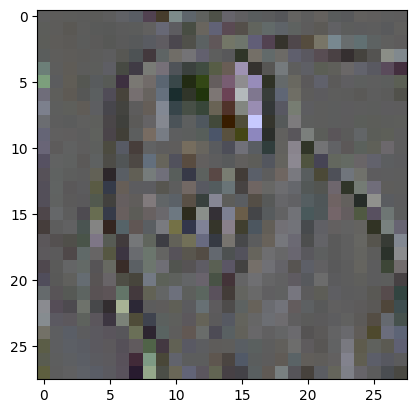

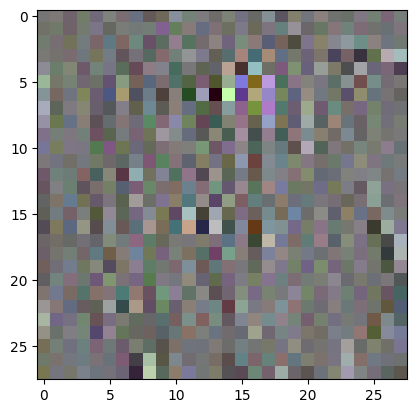

0.03356306254863739
0.035575706511735916


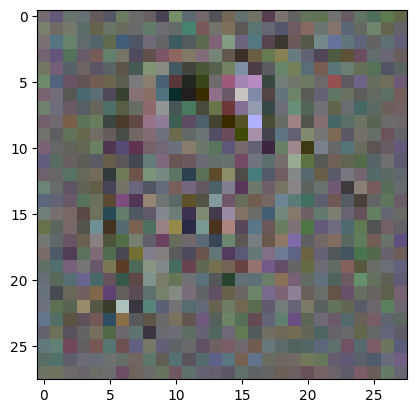

 42%|████▏     | 25/60 [10:47<14:21, 24.61s/it]

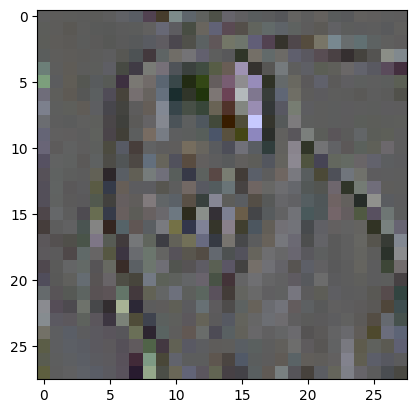

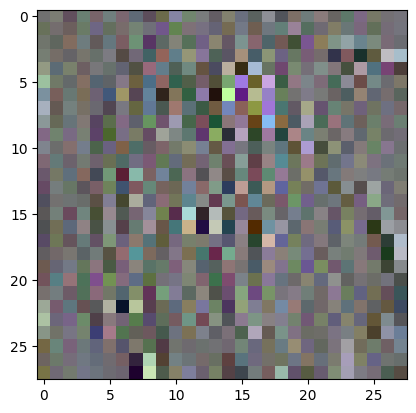

0.03324195370078087
0.034994937479496


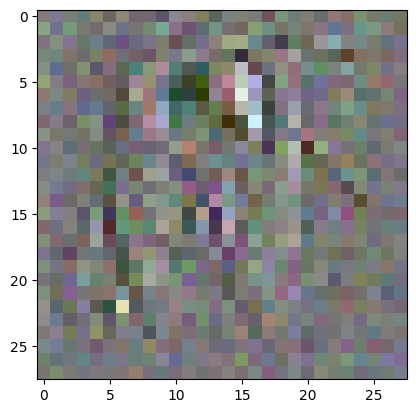

 43%|████▎     | 26/60 [11:11<13:59, 24.69s/it]

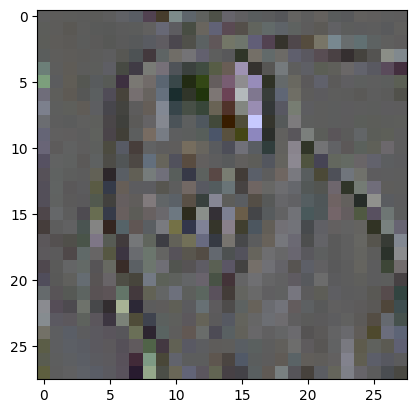

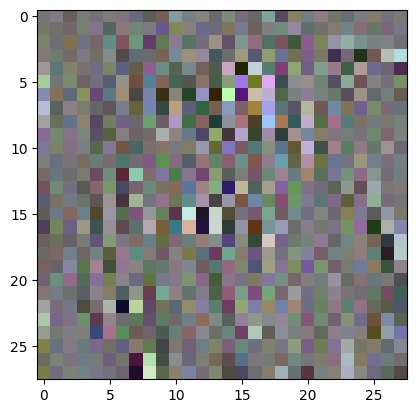

0.032324209809303284
0.03398782014846802


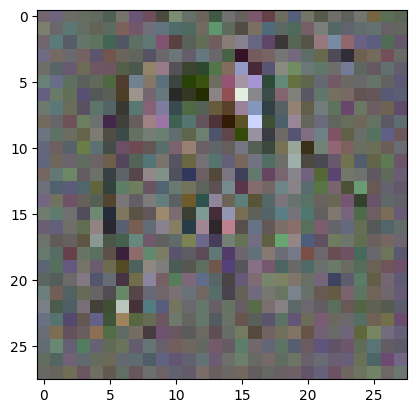

 45%|████▌     | 27/60 [11:36<13:29, 24.54s/it]

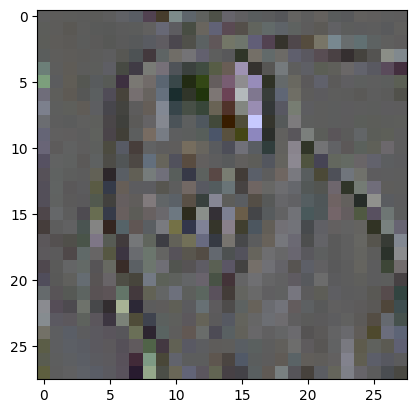

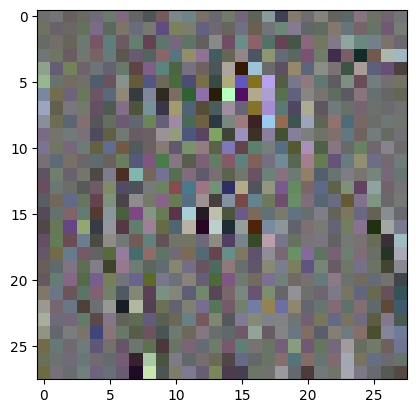

0.03152807429432869
0.033119820058345795


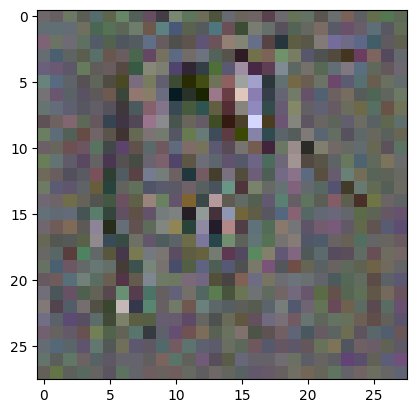

 47%|████▋     | 28/60 [12:00<13:07, 24.60s/it]

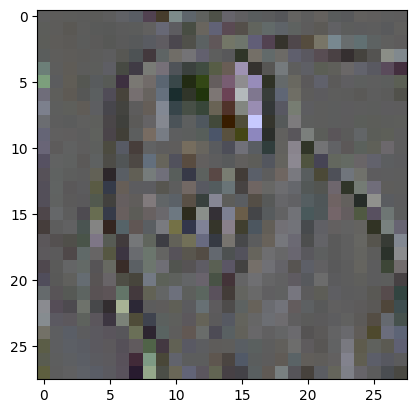

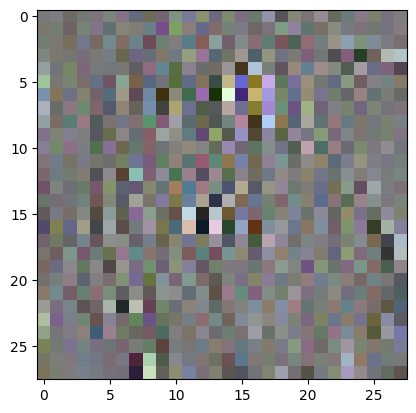

0.031142253428697586
0.03260970860719681


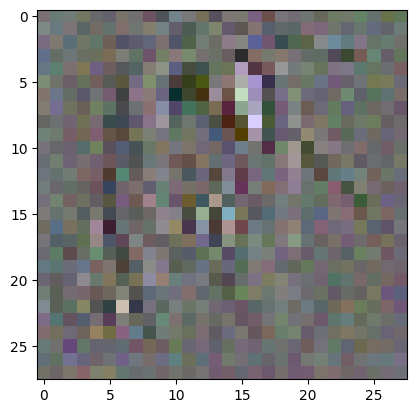

 48%|████▊     | 29/60 [12:26<12:49, 24.82s/it]

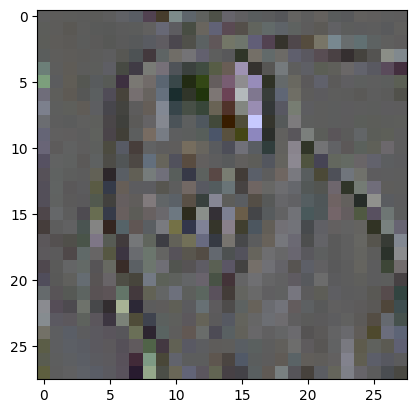

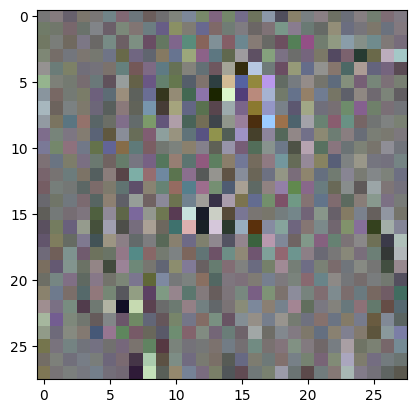

0.03056992031633854
0.03216654807329178


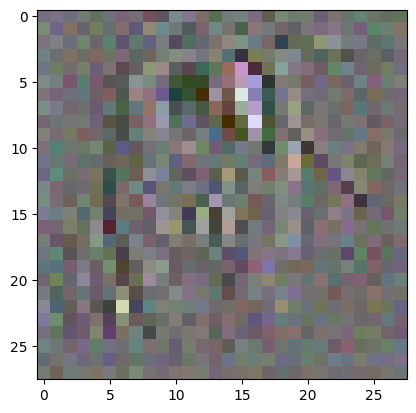

 50%|█████     | 30/60 [12:50<12:23, 24.80s/it]

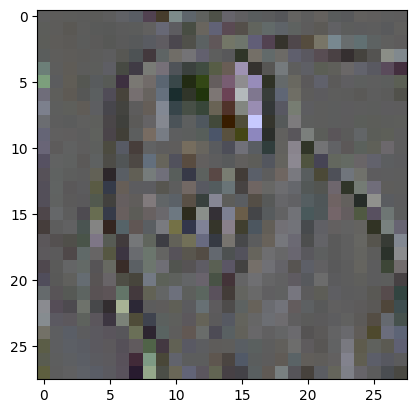

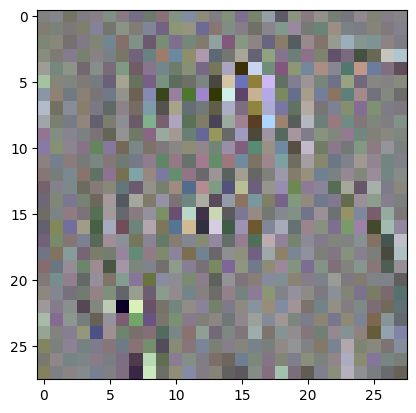

0.030047649517655373
0.03167032450437546


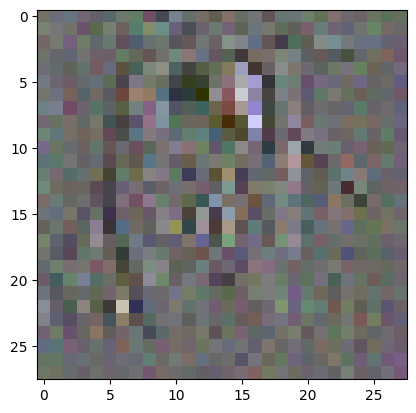

 52%|█████▏    | 31/60 [13:14<11:46, 24.36s/it]

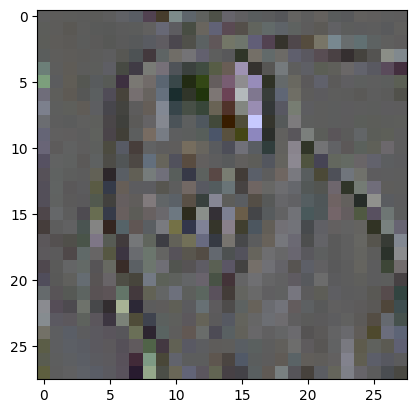

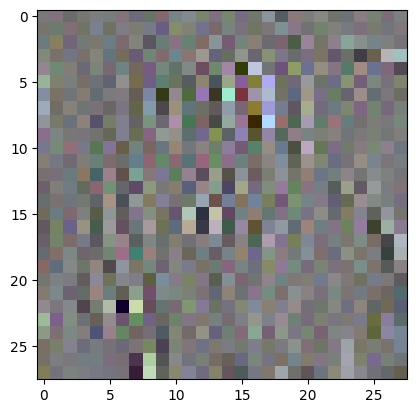

0.03030753694474697
0.03173520788550377


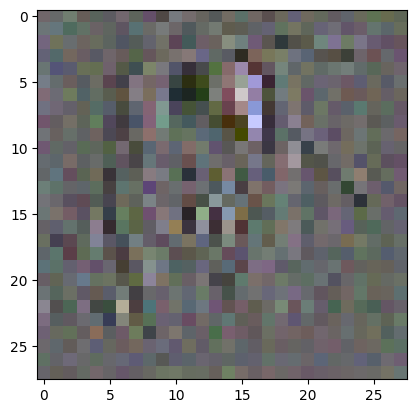

 53%|█████▎    | 32/60 [13:37<11:10, 23.96s/it]

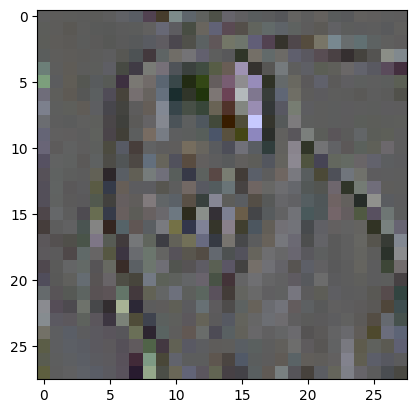

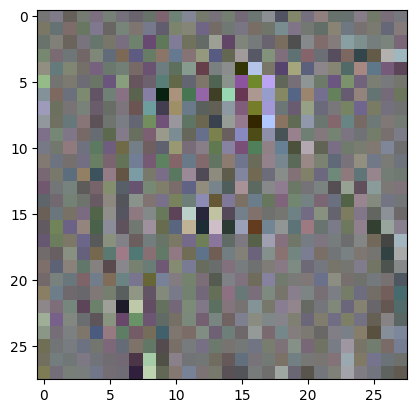

0.02897271327674389
0.030450470745563507


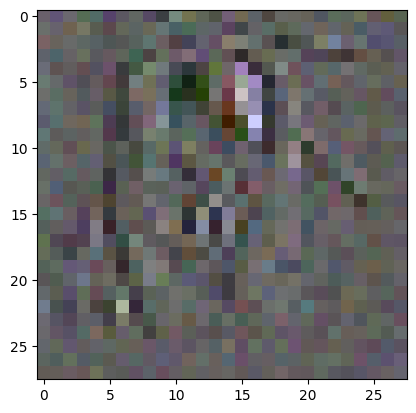

 55%|█████▌    | 33/60 [14:00<10:41, 23.77s/it]

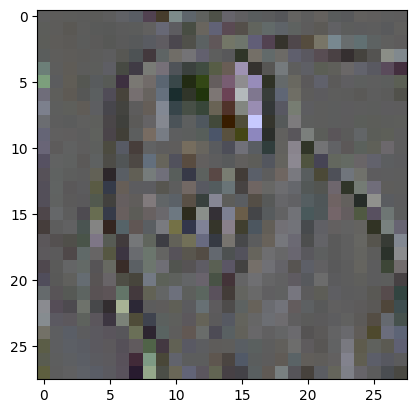

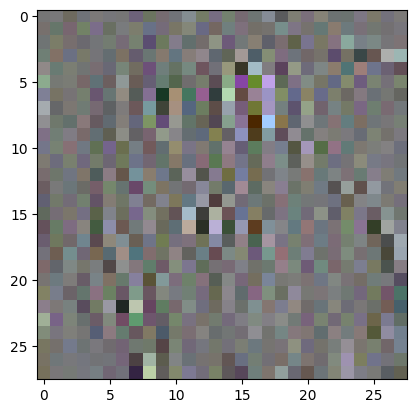

0.02896224334836006
0.0304661076515913


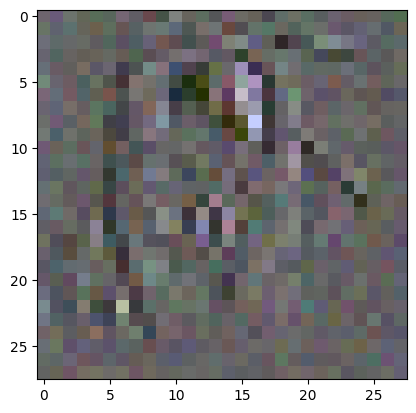

 57%|█████▋    | 34/60 [14:24<10:17, 23.73s/it]

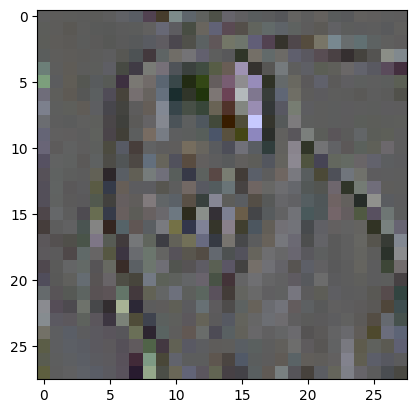

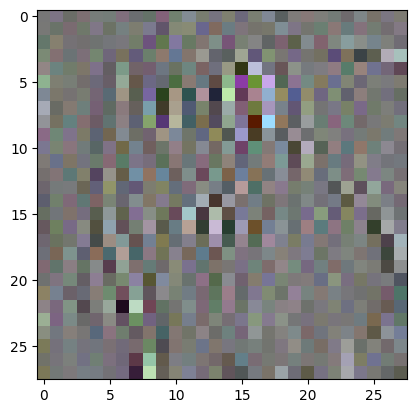

0.029540838673710823
0.03099733777344227


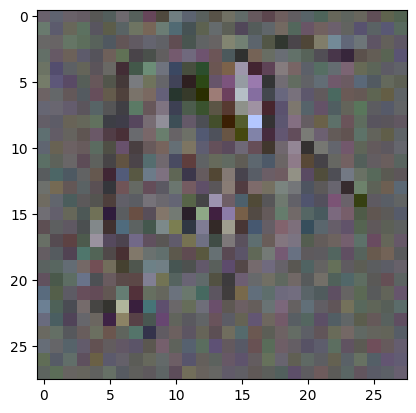

 58%|█████▊    | 35/60 [14:51<10:17, 24.70s/it]

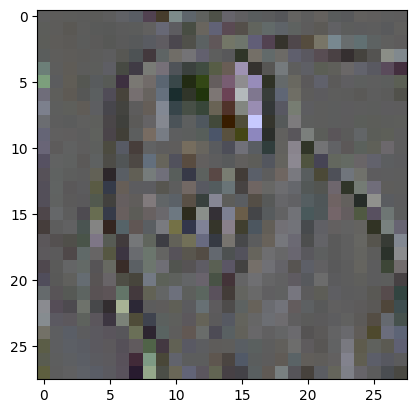

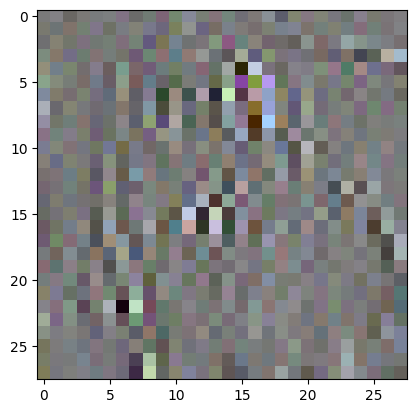

0.02995974011719227
0.031343746930360794


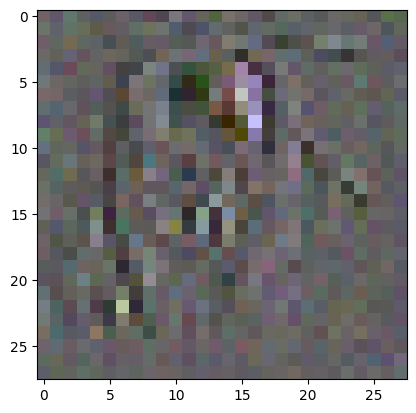

 60%|██████    | 36/60 [15:16<09:55, 24.81s/it]

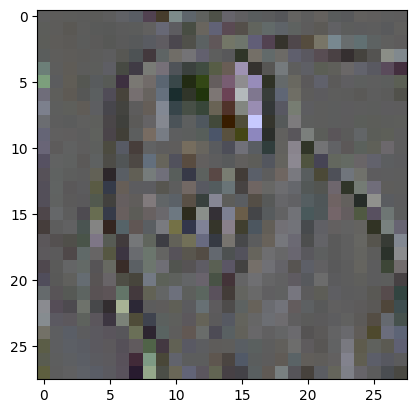

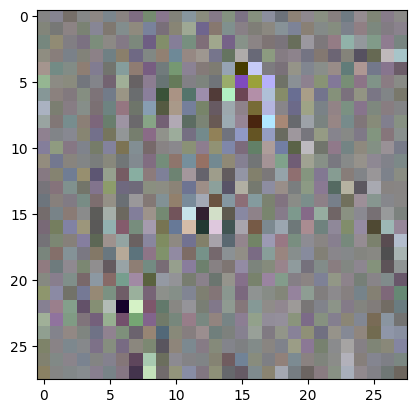

0.02969897724688053
0.030956150963902473


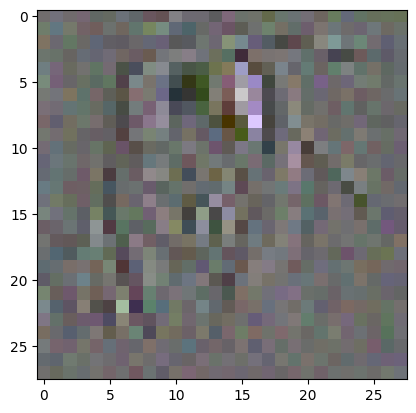

 62%|██████▏   | 37/60 [15:41<09:31, 24.86s/it]

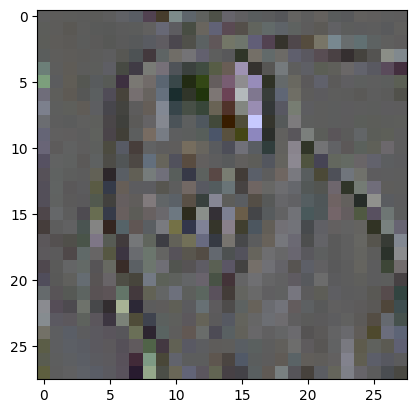

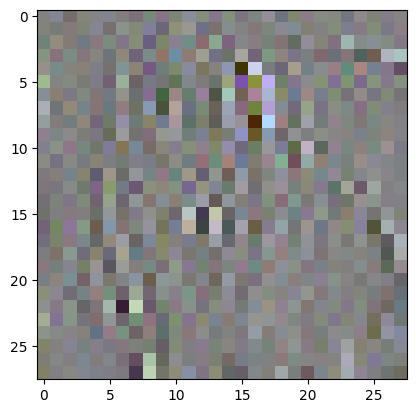

0.027434581890702248
0.02875521406531334


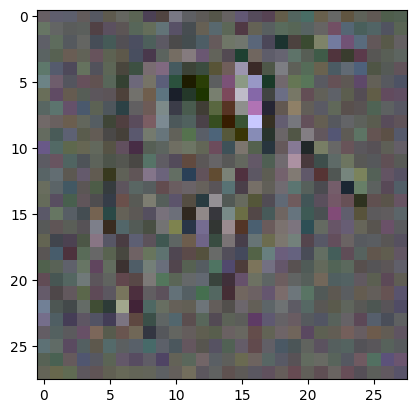

 63%|██████▎   | 38/60 [16:05<09:00, 24.58s/it]

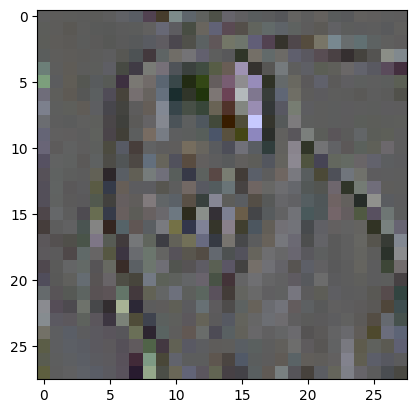

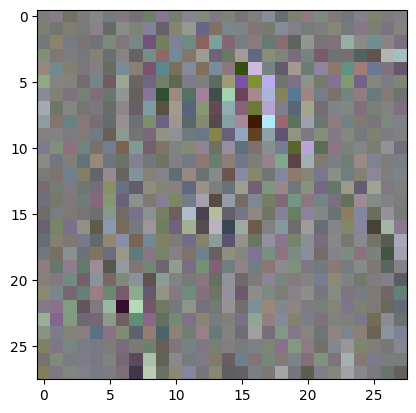

0.02795819193124771
0.029181379824876785


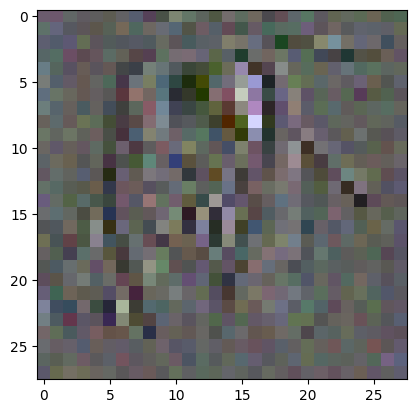

 65%|██████▌   | 39/60 [16:28<08:28, 24.23s/it]

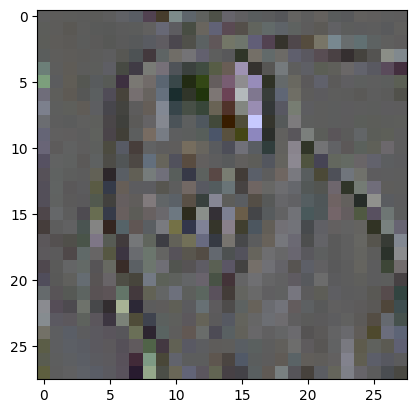

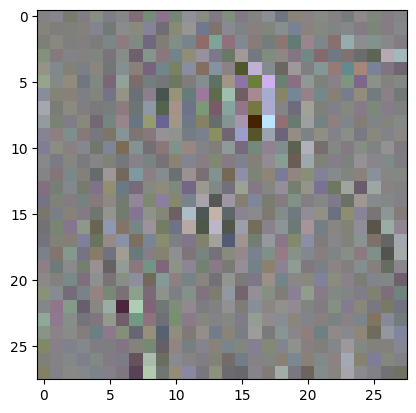

0.02735931985080242
0.028634602203965187


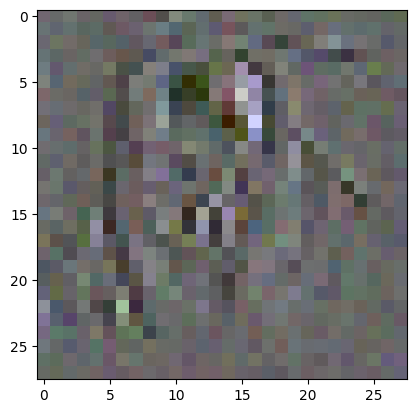

 67%|██████▋   | 40/60 [16:52<08:01, 24.10s/it]

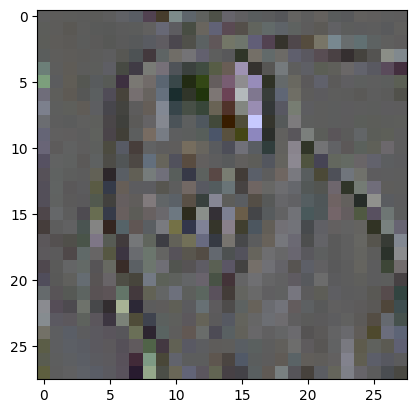

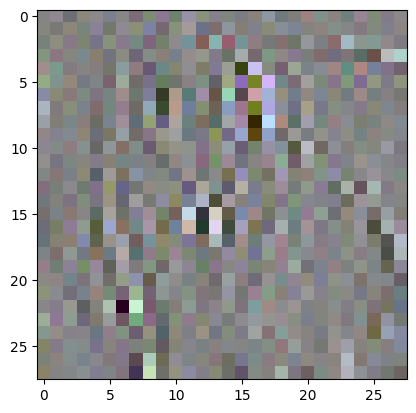

0.02701677940785885
0.028141101822257042


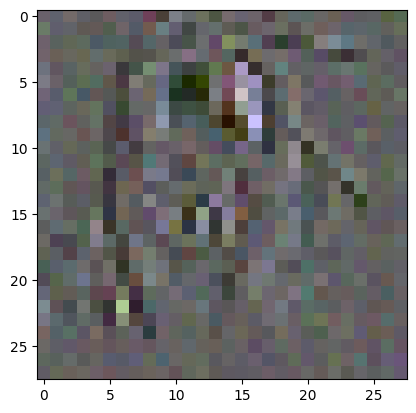

 68%|██████▊   | 41/60 [17:21<08:06, 25.61s/it]

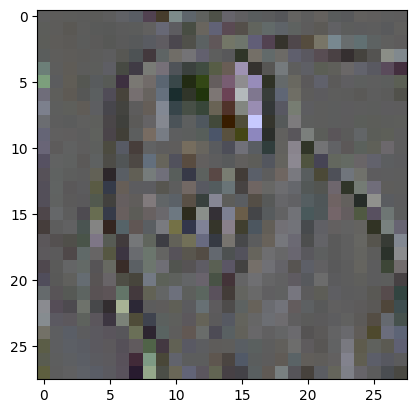

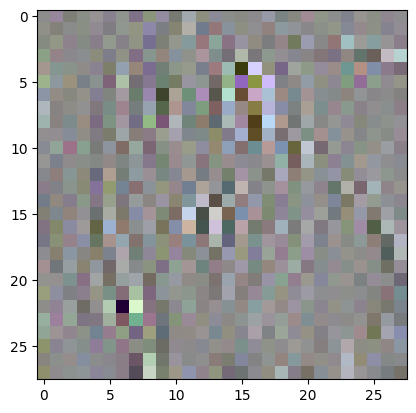

0.027193458750844002
0.02834675833582878


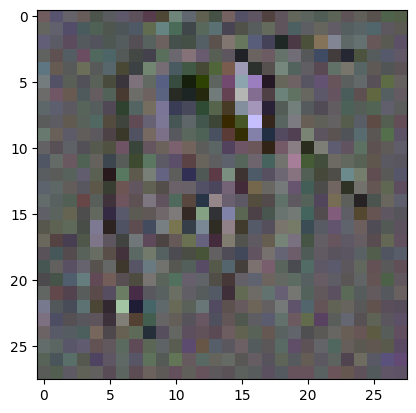

 70%|███████   | 42/60 [17:51<08:03, 26.85s/it]

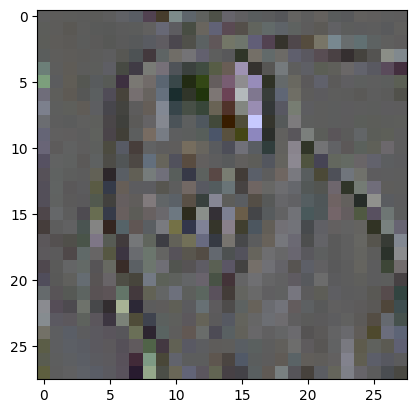

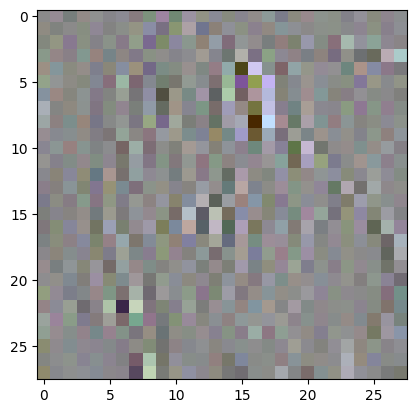

0.027172919362783432
0.028221290558576584


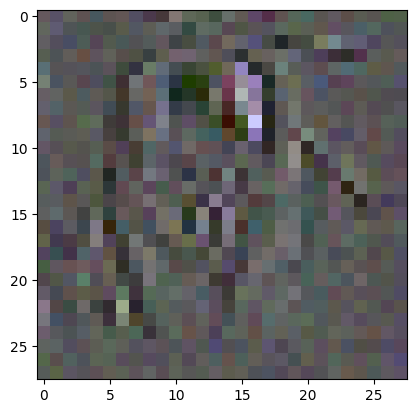

 72%|███████▏  | 43/60 [18:21<07:52, 27.82s/it]

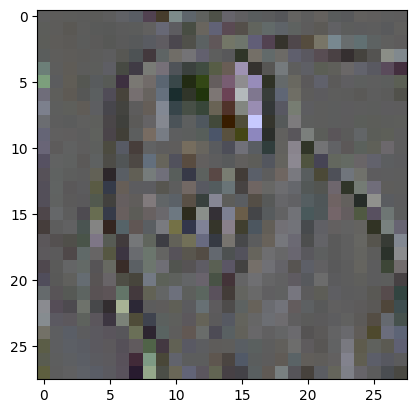

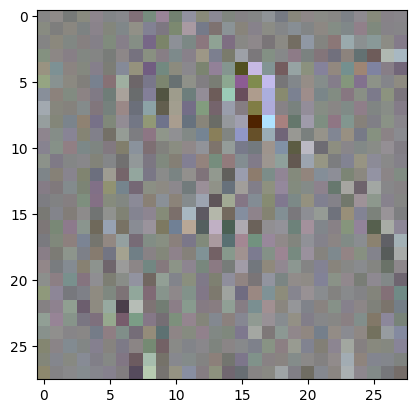

0.025671526789665222
0.026867929846048355


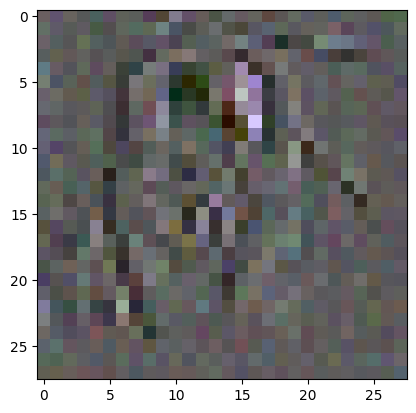

 73%|███████▎  | 44/60 [18:53<07:43, 28.98s/it]

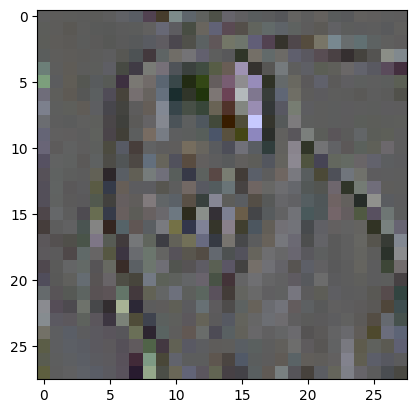

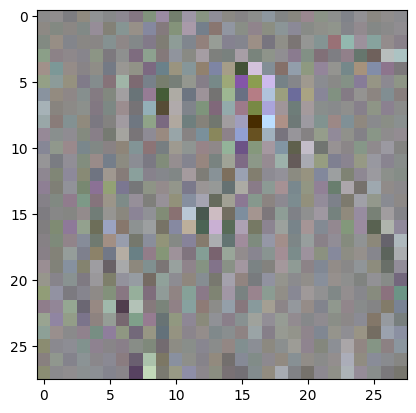

0.02599203959107399
0.02705518528819084


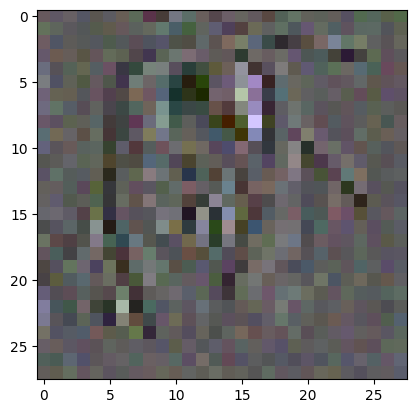

 75%|███████▌  | 45/60 [19:24<07:26, 29.75s/it]

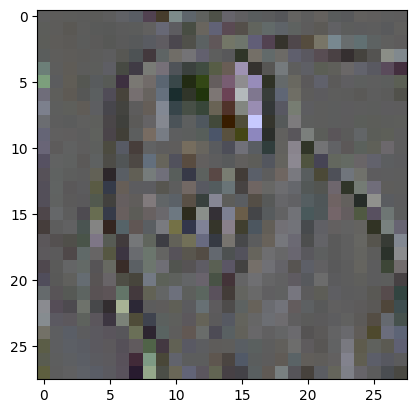

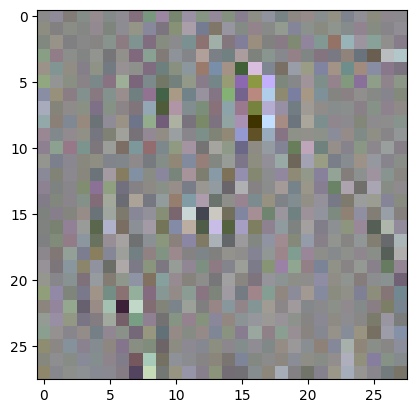

0.025374868884682655
0.026206156238913536


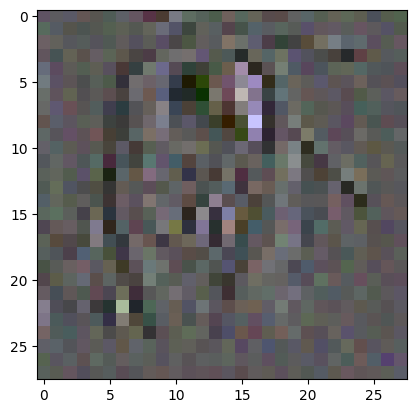

 77%|███████▋  | 46/60 [19:56<07:05, 30.38s/it]

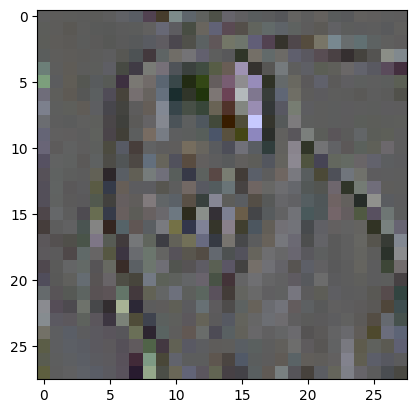

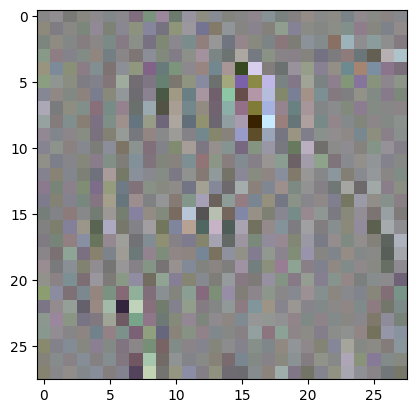

0.025930972769856453
0.026940790936350822


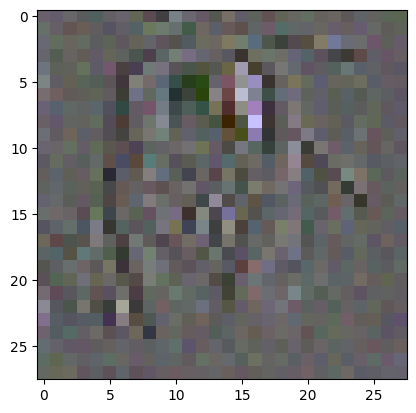

 78%|███████▊  | 47/60 [20:25<06:28, 29.88s/it]

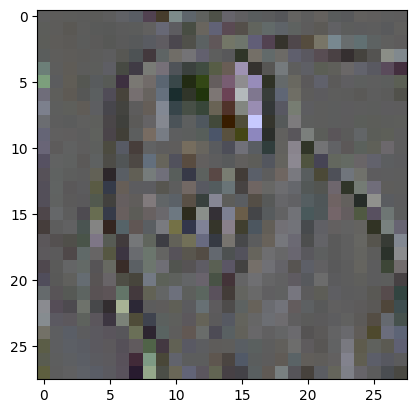

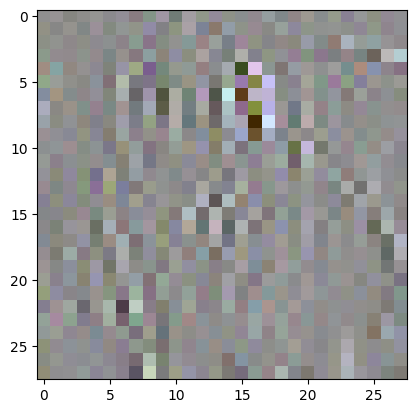

0.027576565742492676
0.028424272313714027


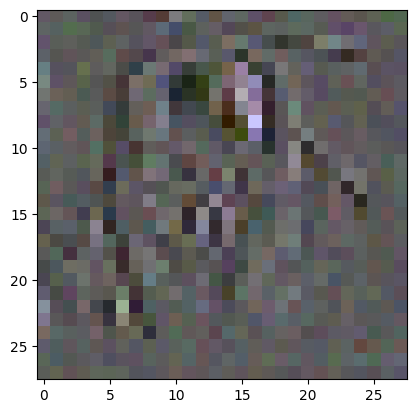

 80%|████████  | 48/60 [20:57<06:08, 30.67s/it]

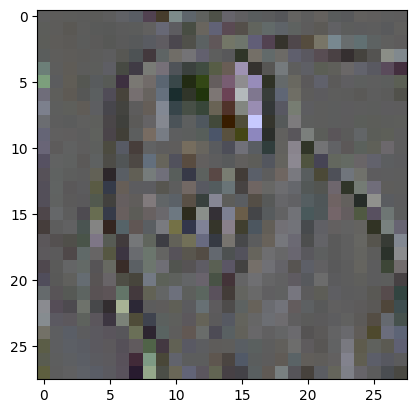

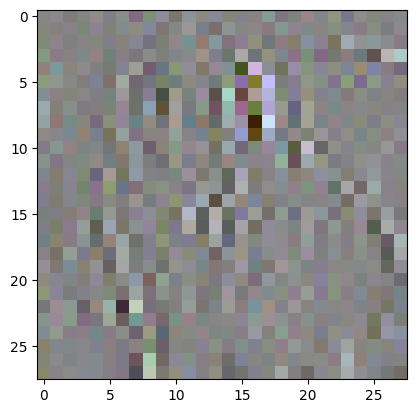

0.025806736201047897
0.026679156348109245


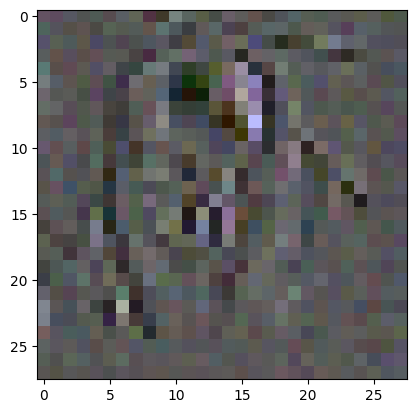

 82%|████████▏ | 49/60 [21:26<05:32, 30.25s/it]

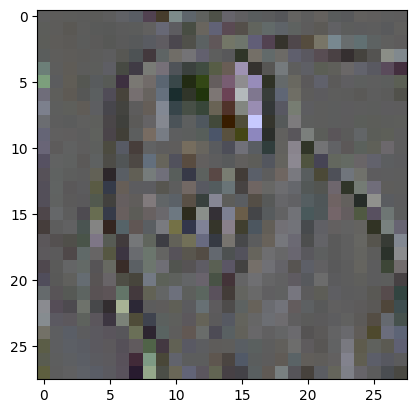

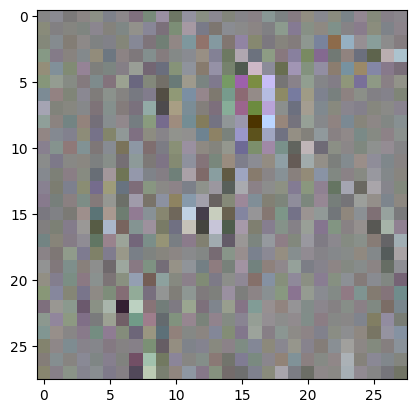

0.025677058845758438
0.02636011689901352


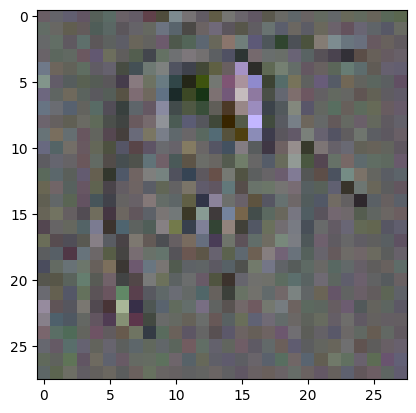

 83%|████████▎ | 50/60 [21:58<05:06, 30.65s/it]

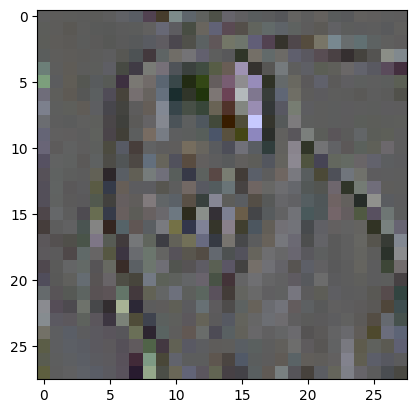

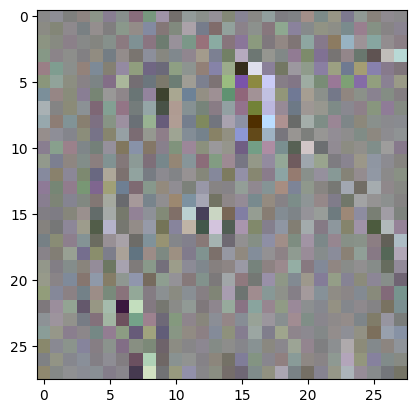

0.024028073996305466
0.02492375858128071


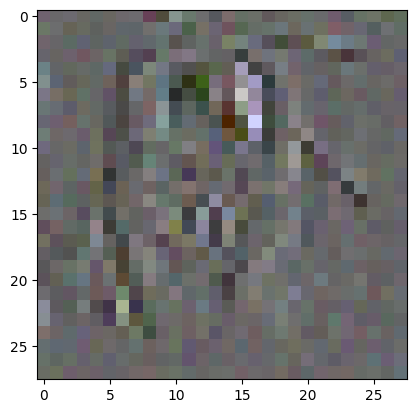

 85%|████████▌ | 51/60 [22:27<04:31, 30.15s/it]

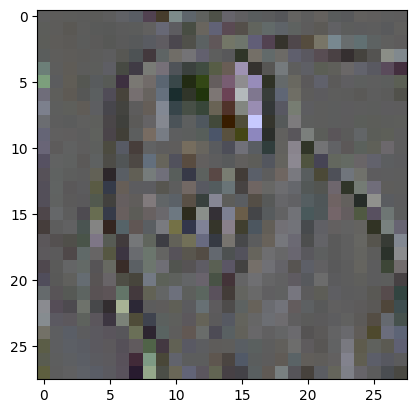

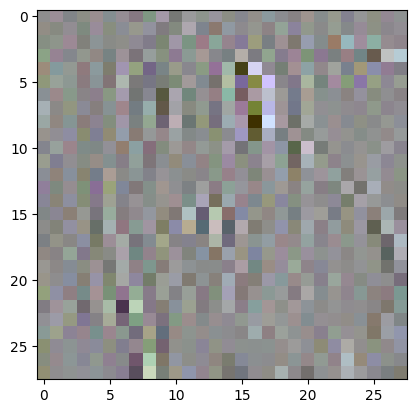

0.02498473785817623
0.025894707068800926


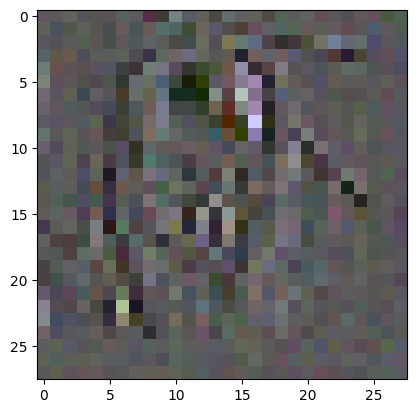

 87%|████████▋ | 52/60 [22:54<03:53, 29.24s/it]

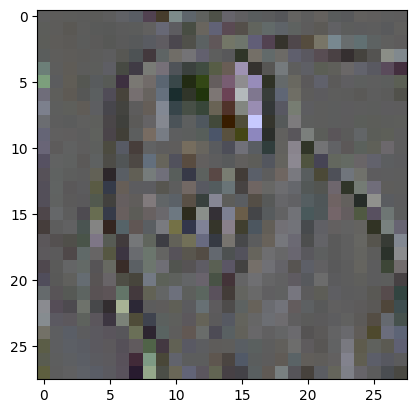

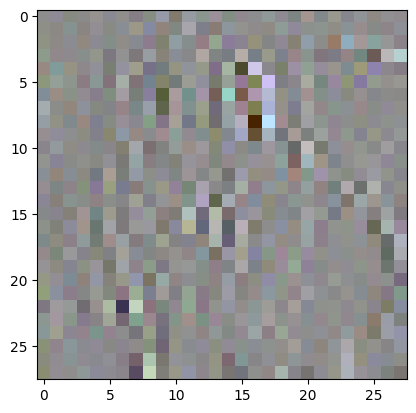

0.023978151381015778
0.024721143767237663


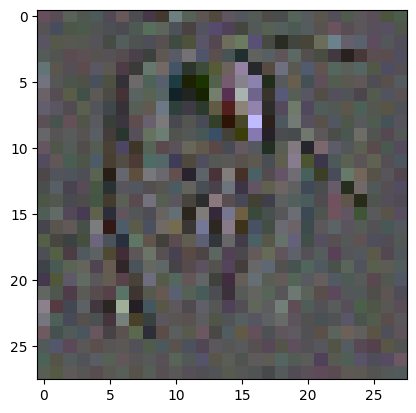

 88%|████████▊ | 53/60 [23:25<03:27, 29.59s/it]

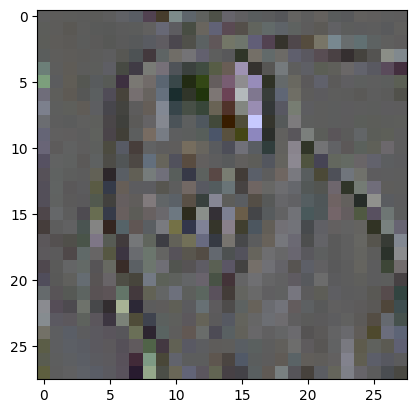

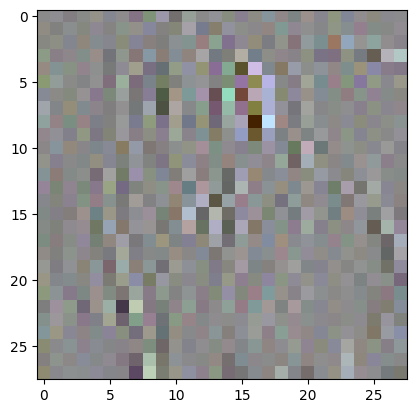

0.024870887398719788
0.02573297545313835


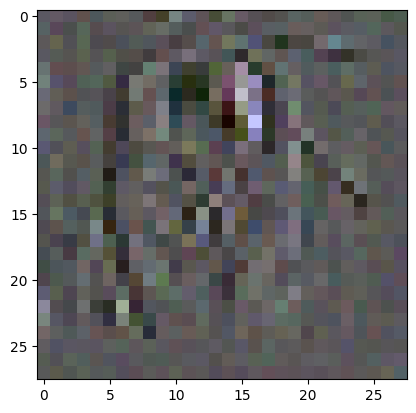

 90%|█████████ | 54/60 [23:54<02:56, 29.46s/it]

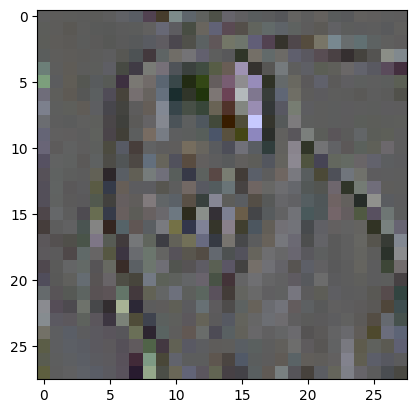

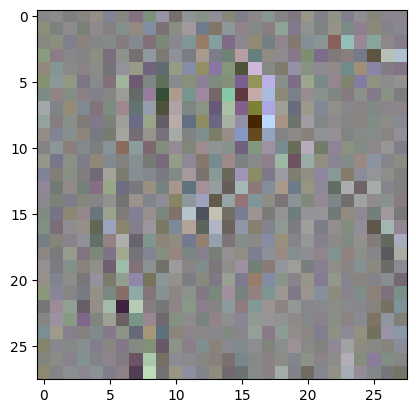

0.0245544221252203
0.025236837565898895


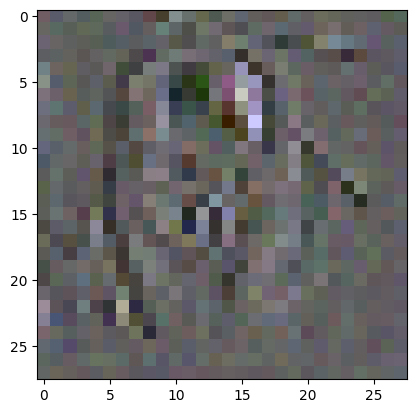

 92%|█████████▏| 55/60 [24:18<02:19, 27.90s/it]

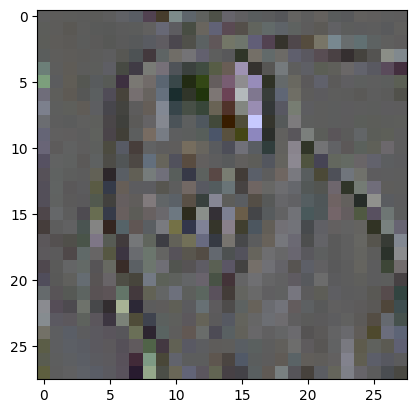

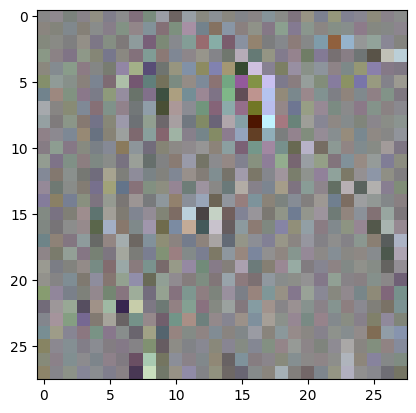

0.02282829023897648
0.02368406392633915


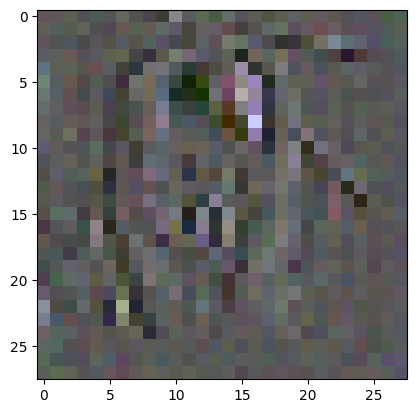

 93%|█████████▎| 56/60 [24:43<01:48, 27.16s/it]

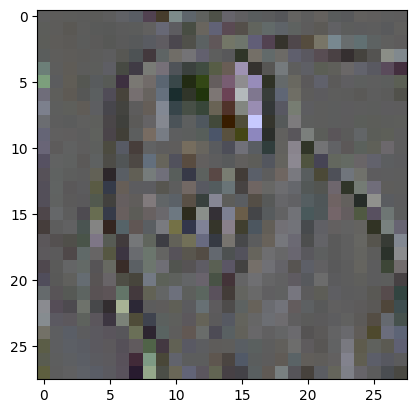

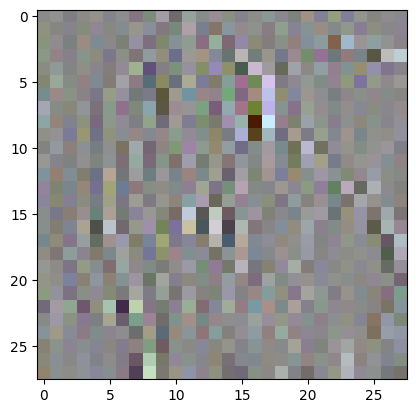

0.024411488324403763
0.025139587000012398


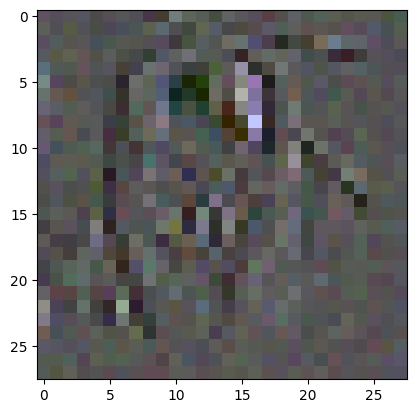

 95%|█████████▌| 57/60 [25:09<01:19, 26.56s/it]

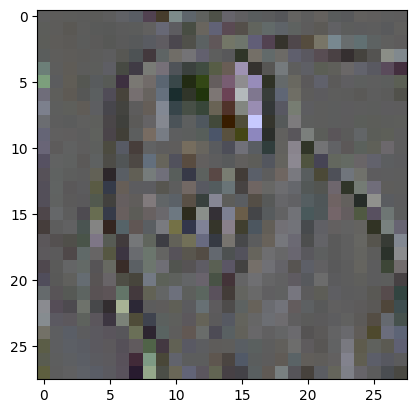

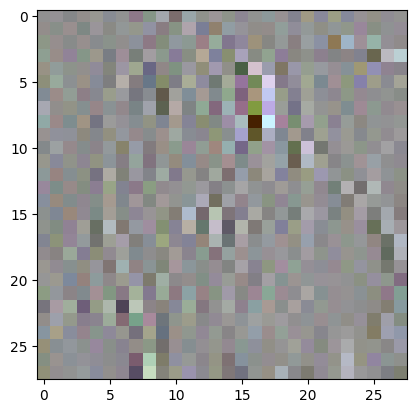

0.02310304157435894
0.023819828405976295


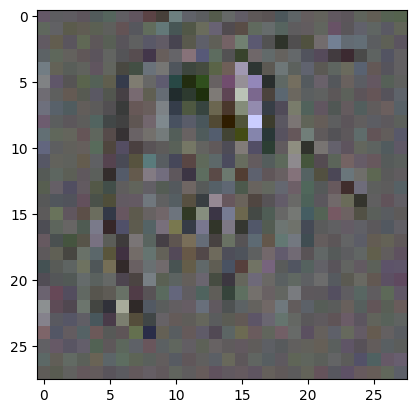

 97%|█████████▋| 58/60 [25:37<00:54, 27.17s/it]

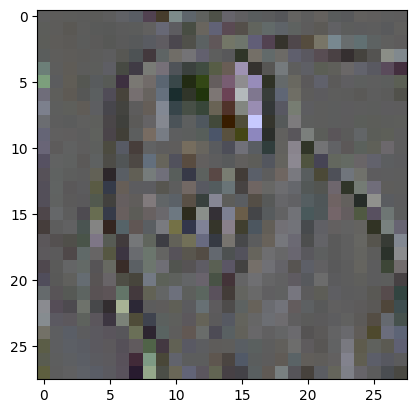

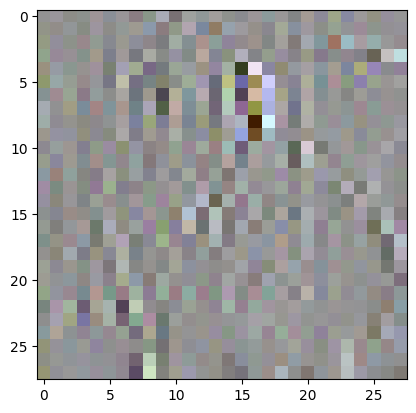

0.023936547338962555
0.024784617125988007


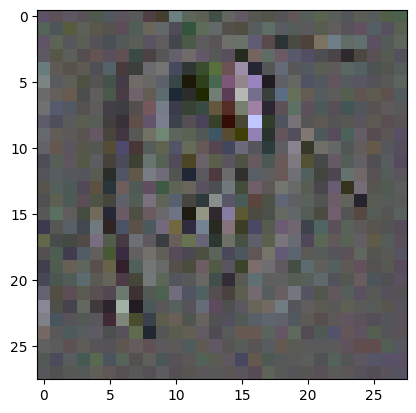

 98%|█████████▊| 59/60 [26:05<00:27, 27.28s/it]

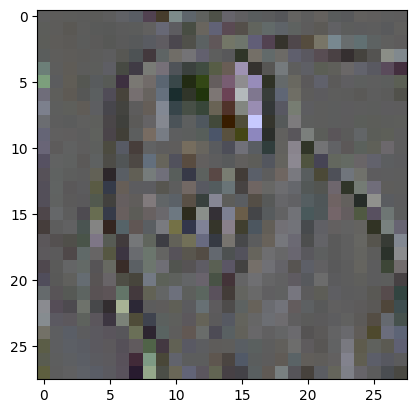

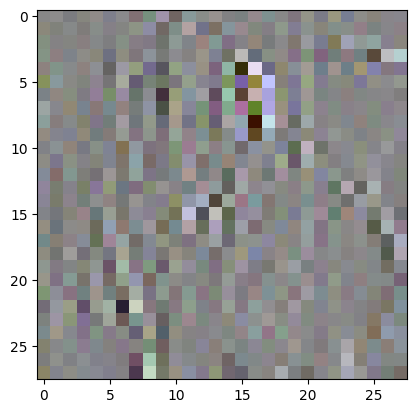

0.02391972206532955
0.024527573958039284


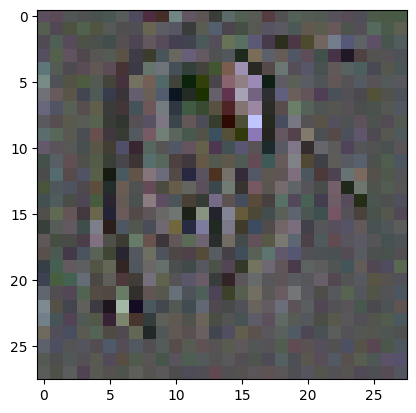

100%|██████████| 60/60 [26:36<00:00, 26.62s/it]


model has been saved


In [10]:

threads = [None] * channels
loss_c_hist = []
loss_hist = []

for e in tqdm(range(epoch)):
  x = torch.zeros((channels, N, H, W))
  m = np.zeros((channels, N, H*W), dtype=np.float32)
  del_m = np.zeros_like(m, dtype=np.float32)
  m_c = np.zeros((channels, N, int((H*W/4))), dtype=np.float32)
  # we want to sample from random time steps to construct training samples
  noise = stats.truncnorm(-dt, dt, loc=0, scale=dt)
  random_t = np.linspace(dt + eps, 1, N-1)
  random_t = np.array([x + noise.rvs(1)[0] for x in random_t])
  random_t[-1] = 1
  time_ = np.sort(np.insert(np.array(random_t), 0, eps)).astype(np.float32)
  sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()
  for idx, x_ in enumerate(cifar_data):
    data = x_
    train_xc_data = torch.zeros((N, channels, int(H/2), int(W/2)))
    train_x_data = torch.zeros((N, channels, H, W))
    train_y_data = torch.zeros_like(train_x_data)
    
    # diffuse all three channels concurrently
    for i in range(channels):
      threads[i] = threading.Thread(target=diffuse, args=[data, x, m, del_m, m_c, i, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_])
      threads[i].start()
    for thread in threads:
      thread.join()
    
    plt.imshow(np.clip((train_y_data[0] + abs(torch.min(train_y_data[0]))) / (torch.max(train_y_data[0]) + abs(torch.min(train_y_data[0]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    plt.imshow(np.clip((train_y_data[-1] + abs(torch.min(train_y_data[-1]))) / (torch.max(train_y_data[-1]) + abs(torch.min(train_y_data[-1]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    yc_pred = model_score(train_xc_data, torch.tensor(time_), coarse=True)
    lm = (2*torch.tensor(sigma_)**2)[:, None, None, None]
    loss = loss_fn(yc_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_c_hist.append(losses)
    print(losses)

    y_pred = model_score(train_x_data, torch.tensor(time_))
    lm = (2*torch.tensor(sigma_)**2)[:, None, None, None]
    loss = loss_fn(y_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_hist.append(losses)
    print(losses)
    scores = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, channels, H, W)) # we normalize before fedding back into PDE
    # scores[1] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W))
    # scores[2] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W))
    plt.imshow(np.moveaxis(np.clip((scores[0] + abs(np.min(scores[0]))) / (np.max(scores[0]) + abs(np.min(scores[0]))), 0, 1).reshape((channels, H, W)), 0, 2))
    plt.show()

torch.save(model_score.state_dict(), 'model_cifar.pth')
print(f"\nmodel has been saved")

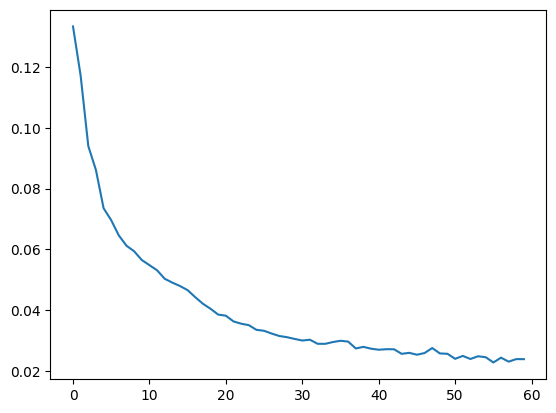

In [11]:
plt.plot(loss_c_hist);